# Afriat

In [1]:
ood_seed = 4

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["time_cat"] = adata.obs["time_cat"].astype(str).astype(float).astype(int).astype(str).astype("category")
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [7]:
df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
availables = list(df[df>100].index)
availables, len(availables)

([('0', 'Pericentral', 'Control'),
  ('0', 'Periportal', 'Control'),
  ('12', 'Pericentral', 'Infected'),
  ('12', 'Pericentral', 'Uninfected'),
  ('12', 'Periportal', 'Infected'),
  ('12', 'Periportal', 'Uninfected'),
  ('2', 'Pericentral', 'Uninfected'),
  ('2', 'Periportal', 'Infected'),
  ('2', 'Periportal', 'Uninfected'),
  ('24', 'Pericentral', 'Infected'),
  ('24', 'Pericentral', 'Uninfected'),
  ('24', 'Periportal', 'Infected'),
  ('24', 'Periportal', 'Uninfected'),
  ('30', 'Pericentral', 'Infected'),
  ('30', 'Pericentral', 'Uninfected'),
  ('30', 'Periportal', 'Infected'),
  ('30', 'Periportal', 'Uninfected'),
  ('36', 'Pericentral', 'Infected'),
  ('36', 'Pericentral', 'Uninfected'),
  ('36', 'Periportal', 'Infected'),
  ('36', 'Periportal', 'Uninfected')],
 21)

In [8]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["time_cat"] == choice[0]) & (adata.obs["zone"] == choice[1]) & (adata.obs["status_control"] == choice[2]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

('12', 'Periportal', 'Infected')


Removed datapoint: 715

train         14699
validation     3639
ood             715
Name: split, dtype: int64

In [9]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [10]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="time_cat",
    control_group="0",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['zone', 'status_control'],
)

  0%|          | 0/19053 [00:00<?, ?it/s]

 45%|████▌     | 8636/19053 [00:00<00:00, 86346.08it/s]

 91%|█████████▏| 17433/19053 [00:00<00:00, 87298.62it/s]

100%|██████████| 19053/19053 [00:00<00:00, 86896.37it/s]

  0%|          | 0/19053 [00:00<?, ?it/s]

100%|██████████| 19053/19053 [00:00<00:00, 1034339.11it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [11]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [12]:
model.train(max_epochs=400)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 485.25it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:09<1:05:14,  9.81s/it]

Epoch 1/400:   0%|          | 1/400 [00:09<1:05:14,  9.81s/it, v_num=1, recon=3.95e+3, r2_mean=0.203, adv_loss=3.28, acc_pert=0.271, acc_zone=0.735, acc_status_control=0.503]

Epoch 2/400:   0%|          | 1/400 [00:09<1:05:14,  9.81s/it, v_num=1, recon=3.95e+3, r2_mean=0.203, adv_loss=3.28, acc_pert=0.271, acc_zone=0.735, acc_status_control=0.503]

Epoch 2/400:   0%|          | 2/400 [00:18<1:01:08,  9.22s/it, v_num=1, recon=3.95e+3, r2_mean=0.203, adv_loss=3.28, acc_pert=0.271, acc_zone=0.735, acc_status_control=0.503]

Epoch 2/400:   0%|          | 2/400 [00:18<1:01:08,  9.22s/it, v_num=1, recon=3.24e+3, r2_mean=0.613, adv_loss=2.84, acc_pert=0.361, acc_zone=0.815, acc_status_control=0.638]

Epoch 3/400:   0%|          | 2/400 [00:18<1:01:08,  9.22s/it, v_num=1, recon=3.24e+3, r2_mean=0.613, adv_loss=2.84, acc_pert=0.361, acc_zone=0.815, acc_status_control=0.638]

Epoch 3/400:   1%|          | 3/400 [00:27<59:17,  8.96s/it, v_num=1, recon=3.24e+3, r2_mean=0.613, adv_loss=2.84, acc_pert=0.361, acc_zone=0.815, acc_status_control=0.638]  

Epoch 3/400:   1%|          | 3/400 [00:27<59:17,  8.96s/it, v_num=1, recon=3.18e+3, r2_mean=0.715, adv_loss=2.76, acc_pert=0.392, acc_zone=0.822, acc_status_control=0.647]

Epoch 4/400:   1%|          | 3/400 [00:27<59:17,  8.96s/it, v_num=1, recon=3.18e+3, r2_mean=0.715, adv_loss=2.76, acc_pert=0.392, acc_zone=0.822, acc_status_control=0.647]

Epoch 4/400:   1%|          | 4/400 [00:35<58:21,  8.84s/it, v_num=1, recon=3.18e+3, r2_mean=0.715, adv_loss=2.76, acc_pert=0.392, acc_zone=0.822, acc_status_control=0.647]

Epoch 4/400:   1%|          | 4/400 [00:35<58:21,  8.84s/it, v_num=1, recon=3.17e+3, r2_mean=0.747, adv_loss=2.72, acc_pert=0.412, acc_zone=0.82, acc_status_control=0.64]  

Epoch 5/400:   1%|          | 4/400 [00:35<58:21,  8.84s/it, v_num=1, recon=3.17e+3, r2_mean=0.747, adv_loss=2.72, acc_pert=0.412, acc_zone=0.82, acc_status_control=0.64]

Epoch 5/400:   1%|▏         | 5/400 [00:44<58:07,  8.83s/it, v_num=1, recon=3.17e+3, r2_mean=0.747, adv_loss=2.72, acc_pert=0.412, acc_zone=0.82, acc_status_control=0.64]

Epoch 5/400:   1%|▏         | 5/400 [00:44<58:07,  8.83s/it, v_num=1, recon=3.15e+3, r2_mean=0.772, adv_loss=2.54, acc_pert=0.491, acc_zone=0.826, acc_status_control=0.642]

Epoch 6/400:   1%|▏         | 5/400 [00:44<58:07,  8.83s/it, v_num=1, recon=3.15e+3, r2_mean=0.772, adv_loss=2.54, acc_pert=0.491, acc_zone=0.826, acc_status_control=0.642]

Epoch 6/400:   2%|▏         | 6/400 [00:53<57:51,  8.81s/it, v_num=1, recon=3.15e+3, r2_mean=0.772, adv_loss=2.54, acc_pert=0.491, acc_zone=0.826, acc_status_control=0.642]

Epoch 6/400:   2%|▏         | 6/400 [00:53<57:51,  8.81s/it, v_num=1, recon=3.14e+3, r2_mean=0.786, adv_loss=2.38, acc_pert=0.544, acc_zone=0.829, acc_status_control=0.644]

Epoch 7/400:   2%|▏         | 6/400 [00:53<57:51,  8.81s/it, v_num=1, recon=3.14e+3, r2_mean=0.786, adv_loss=2.38, acc_pert=0.544, acc_zone=0.829, acc_status_control=0.644]

Epoch 7/400:   2%|▏         | 7/400 [01:02<57:39,  8.80s/it, v_num=1, recon=3.14e+3, r2_mean=0.786, adv_loss=2.38, acc_pert=0.544, acc_zone=0.829, acc_status_control=0.644]

Epoch 7/400:   2%|▏         | 7/400 [01:02<57:39,  8.80s/it, v_num=1, recon=3.13e+3, r2_mean=0.8, adv_loss=2.25, acc_pert=0.583, acc_zone=0.837, acc_status_control=0.643]  

Epoch 8/400:   2%|▏         | 7/400 [01:02<57:39,  8.80s/it, v_num=1, recon=3.13e+3, r2_mean=0.8, adv_loss=2.25, acc_pert=0.583, acc_zone=0.837, acc_status_control=0.643]

Epoch 8/400:   2%|▏         | 8/400 [01:11<57:30,  8.80s/it, v_num=1, recon=3.13e+3, r2_mean=0.8, adv_loss=2.25, acc_pert=0.583, acc_zone=0.837, acc_status_control=0.643]

Epoch 8/400:   2%|▏         | 8/400 [01:11<57:30,  8.80s/it, v_num=1, recon=3.12e+3, r2_mean=0.803, adv_loss=2.11, acc_pert=0.625, acc_zone=0.841, acc_status_control=0.651]

Epoch 9/400:   2%|▏         | 8/400 [01:11<57:30,  8.80s/it, v_num=1, recon=3.12e+3, r2_mean=0.803, adv_loss=2.11, acc_pert=0.625, acc_zone=0.841, acc_status_control=0.651]

Epoch 9/400:   2%|▏         | 9/400 [01:19<57:19,  8.80s/it, v_num=1, recon=3.12e+3, r2_mean=0.803, adv_loss=2.11, acc_pert=0.625, acc_zone=0.841, acc_status_control=0.651]

Epoch 9/400:   2%|▏         | 9/400 [01:19<57:19,  8.80s/it, v_num=1, recon=3.11e+3, r2_mean=0.807, adv_loss=2.03, acc_pert=0.655, acc_zone=0.849, acc_status_control=0.655]

Epoch 10/400:   2%|▏         | 9/400 [01:19<57:19,  8.80s/it, v_num=1, recon=3.11e+3, r2_mean=0.807, adv_loss=2.03, acc_pert=0.655, acc_zone=0.849, acc_status_control=0.655]


disnt_basal = 1.2519845129970606

disnt_after = 1.8786383196246517

val_r2_mean = 0.8001079681414381

val_r2_var = 0.18451755198351655


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [02:11<2:23:00, 22.00s/it, v_num=1, recon=3.11e+3, r2_mean=0.807, adv_loss=2.03, acc_pert=0.655, acc_zone=0.849, acc_status_control=0.655]

Epoch 10/400:   2%|▎         | 10/400 [02:11<2:23:00, 22.00s/it, v_num=1, recon=3.11e+3, r2_mean=0.81, adv_loss=2, acc_pert=0.666, acc_zone=0.848, acc_status_control=0.657, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.8, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [02:11<2:23:00, 22.00s/it, v_num=1, recon=3.11e+3, r2_mean=0.81, adv_loss=2, acc_pert=0.666, acc_zone=0.848, acc_status_control=0.657, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.8, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [02:20<1:56:44, 18.01s/it, v_num=1, recon=3.11e+3, r2_mean=0.81, adv_loss=2, acc_pert=0.666, acc_zone=0.848, acc_status_control=0.657, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.8, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [02:20<1:56:44, 18.01s/it, v_num=1, recon=3.1e+3, r2_mean=0.813, adv_loss=1.97, acc_pert=0.67, acc_zone=0.852, acc_status_control=0.656, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.8, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [02:20<1:56:44, 18.01s/it, v_num=1, recon=3.1e+3, r2_mean=0.813, adv_loss=1.97, acc_pert=0.67, acc_zone=0.852, acc_status_control=0.656, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.8, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [02:29<1:38:36, 15.25s/it, v_num=1, recon=3.1e+3, r2_mean=0.813, adv_loss=1.97, acc_pert=0.67, acc_zone=0.852, acc_status_control=0.656, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.8, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [02:29<1:38:36, 15.25s/it, v_num=1, recon=3.1e+3, r2_mean=0.815, adv_loss=1.95, acc_pert=0.675, acc_zone=0.852, acc_status_control=0.663, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.8, val_KL=nan]

Epoch 13/400:   3%|▎         | 12/400 [02:29<1:38:36, 15.25s/it, v_num=1, recon=3.1e+3, r2_mean=0.815, adv_loss=1.95, acc_pert=0.675, acc_zone=0.852, acc_status_control=0.663, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.8, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [02:38<1:26:20, 13.39s/it, v_num=1, recon=3.1e+3, r2_mean=0.815, adv_loss=1.95, acc_pert=0.675, acc_zone=0.852, acc_status_control=0.663, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.8, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [02:38<1:26:20, 13.39s/it, v_num=1, recon=3.09e+3, r2_mean=0.816, adv_loss=1.95, acc_pert=0.681, acc_zone=0.852, acc_status_control=0.656, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.8, val_KL=nan]

Epoch 14/400:   3%|▎         | 13/400 [02:38<1:26:20, 13.39s/it, v_num=1, recon=3.09e+3, r2_mean=0.816, adv_loss=1.95, acc_pert=0.681, acc_zone=0.852, acc_status_control=0.656, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.8, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [02:47<1:17:23, 12.03s/it, v_num=1, recon=3.09e+3, r2_mean=0.816, adv_loss=1.95, acc_pert=0.681, acc_zone=0.852, acc_status_control=0.656, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.8, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [02:47<1:17:23, 12.03s/it, v_num=1, recon=3.09e+3, r2_mean=0.816, adv_loss=1.95, acc_pert=0.673, acc_zone=0.852, acc_status_control=0.658, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.8, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [02:47<1:17:23, 12.03s/it, v_num=1, recon=3.09e+3, r2_mean=0.816, adv_loss=1.95, acc_pert=0.673, acc_zone=0.852, acc_status_control=0.658, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.8, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [02:56<1:10:56, 11.06s/it, v_num=1, recon=3.09e+3, r2_mean=0.816, adv_loss=1.95, acc_pert=0.673, acc_zone=0.852, acc_status_control=0.658, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.8, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [02:56<1:10:56, 11.06s/it, v_num=1, recon=3.08e+3, r2_mean=0.821, adv_loss=1.95, acc_pert=0.669, acc_zone=0.852, acc_status_control=0.659, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.8, val_KL=nan]

Epoch 16/400:   4%|▍         | 15/400 [02:56<1:10:56, 11.06s/it, v_num=1, recon=3.08e+3, r2_mean=0.821, adv_loss=1.95, acc_pert=0.669, acc_zone=0.852, acc_status_control=0.659, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.8, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [03:04<1:06:15, 10.35s/it, v_num=1, recon=3.08e+3, r2_mean=0.821, adv_loss=1.95, acc_pert=0.669, acc_zone=0.852, acc_status_control=0.659, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.8, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [03:04<1:06:15, 10.35s/it, v_num=1, recon=3.08e+3, r2_mean=0.824, adv_loss=1.94, acc_pert=0.674, acc_zone=0.851, acc_status_control=0.658, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.8, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [03:04<1:06:15, 10.35s/it, v_num=1, recon=3.08e+3, r2_mean=0.824, adv_loss=1.94, acc_pert=0.674, acc_zone=0.851, acc_status_control=0.658, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.8, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [03:13<1:03:03,  9.88s/it, v_num=1, recon=3.08e+3, r2_mean=0.824, adv_loss=1.94, acc_pert=0.674, acc_zone=0.851, acc_status_control=0.658, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.8, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [03:13<1:03:03,  9.88s/it, v_num=1, recon=3.07e+3, r2_mean=0.823, adv_loss=1.9, acc_pert=0.685, acc_zone=0.849, acc_status_control=0.662, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.8, val_KL=nan] 

Epoch 18/400:   4%|▍         | 17/400 [03:13<1:03:03,  9.88s/it, v_num=1, recon=3.07e+3, r2_mean=0.823, adv_loss=1.9, acc_pert=0.685, acc_zone=0.849, acc_status_control=0.662, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.8, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [03:22<1:00:48,  9.55s/it, v_num=1, recon=3.07e+3, r2_mean=0.823, adv_loss=1.9, acc_pert=0.685, acc_zone=0.849, acc_status_control=0.662, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.8, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [03:22<1:00:48,  9.55s/it, v_num=1, recon=3.07e+3, r2_mean=0.823, adv_loss=1.9, acc_pert=0.691, acc_zone=0.849, acc_status_control=0.663, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.8, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [03:22<1:00:48,  9.55s/it, v_num=1, recon=3.07e+3, r2_mean=0.823, adv_loss=1.9, acc_pert=0.691, acc_zone=0.849, acc_status_control=0.663, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.8, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [03:31<58:59,  9.29s/it, v_num=1, recon=3.07e+3, r2_mean=0.823, adv_loss=1.9, acc_pert=0.691, acc_zone=0.849, acc_status_control=0.663, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.8, val_KL=nan]  

Epoch 19/400:   5%|▍         | 19/400 [03:31<58:59,  9.29s/it, v_num=1, recon=3.07e+3, r2_mean=0.823, adv_loss=1.88, acc_pert=0.691, acc_zone=0.852, acc_status_control=0.665, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.8, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [03:31<58:59,  9.29s/it, v_num=1, recon=3.07e+3, r2_mean=0.823, adv_loss=1.88, acc_pert=0.691, acc_zone=0.852, acc_status_control=0.665, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.8, val_KL=nan]


disnt_basal = 1.2465544158637418

disnt_after = 1.8496581967711307

val_r2_mean = 0.8165874326662388

val_r2_var = 0.22477939713743547

Epoch 20/400:   5%|▌         | 20/400 [04:29<2:31:40, 23.95s/it, v_num=1, recon=3.07e+3, r2_mean=0.823, adv_loss=1.88, acc_pert=0.691, acc_zone=0.852, acc_status_control=0.665, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.8, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [04:29<2:31:40, 23.95s/it, v_num=1, recon=3.06e+3, r2_mean=0.823, adv_loss=1.87, acc_pert=0.696, acc_zone=0.846, acc_status_control=0.665, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.817, val_KL=nan]

Epoch 21/400:   5%|▌         | 20/400 [04:29<2:31:40, 23.95s/it, v_num=1, recon=3.06e+3, r2_mean=0.823, adv_loss=1.87, acc_pert=0.696, acc_zone=0.846, acc_status_control=0.665, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.817, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [04:47<2:19:35, 22.10s/it, v_num=1, recon=3.06e+3, r2_mean=0.823, adv_loss=1.87, acc_pert=0.696, acc_zone=0.846, acc_status_control=0.665, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.817, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [04:47<2:19:35, 22.10s/it, v_num=1, recon=3.06e+3, r2_mean=0.826, adv_loss=1.85, acc_pert=0.698, acc_zone=0.851, acc_status_control=0.673, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.817, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [04:47<2:19:35, 22.10s/it, v_num=1, recon=3.06e+3, r2_mean=0.826, adv_loss=1.85, acc_pert=0.698, acc_zone=0.851, acc_status_control=0.673, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.817, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [04:55<1:54:09, 18.12s/it, v_num=1, recon=3.06e+3, r2_mean=0.826, adv_loss=1.85, acc_pert=0.698, acc_zone=0.851, acc_status_control=0.673, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.817, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [04:55<1:54:09, 18.12s/it, v_num=1, recon=3.05e+3, r2_mean=0.825, adv_loss=1.86, acc_pert=0.699, acc_zone=0.848, acc_status_control=0.674, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.817, val_KL=nan]

Epoch 23/400:   6%|▌         | 22/400 [04:55<1:54:09, 18.12s/it, v_num=1, recon=3.05e+3, r2_mean=0.825, adv_loss=1.86, acc_pert=0.699, acc_zone=0.848, acc_status_control=0.674, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.817, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [05:04<1:36:29, 15.36s/it, v_num=1, recon=3.05e+3, r2_mean=0.825, adv_loss=1.86, acc_pert=0.699, acc_zone=0.848, acc_status_control=0.674, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.817, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [05:04<1:36:29, 15.36s/it, v_num=1, recon=3.05e+3, r2_mean=0.828, adv_loss=1.88, acc_pert=0.695, acc_zone=0.849, acc_status_control=0.672, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.817, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [05:04<1:36:29, 15.36s/it, v_num=1, recon=3.05e+3, r2_mean=0.828, adv_loss=1.88, acc_pert=0.695, acc_zone=0.849, acc_status_control=0.672, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.817, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [05:13<1:23:52, 13.39s/it, v_num=1, recon=3.05e+3, r2_mean=0.828, adv_loss=1.88, acc_pert=0.695, acc_zone=0.849, acc_status_control=0.672, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.817, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [05:13<1:23:52, 13.39s/it, v_num=1, recon=3.05e+3, r2_mean=0.826, adv_loss=1.87, acc_pert=0.697, acc_zone=0.851, acc_status_control=0.67, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.817, val_KL=nan] 

Epoch 25/400:   6%|▌         | 24/400 [05:13<1:23:52, 13.39s/it, v_num=1, recon=3.05e+3, r2_mean=0.826, adv_loss=1.87, acc_pert=0.697, acc_zone=0.851, acc_status_control=0.67, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.817, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [05:22<1:14:55, 11.99s/it, v_num=1, recon=3.05e+3, r2_mean=0.826, adv_loss=1.87, acc_pert=0.697, acc_zone=0.851, acc_status_control=0.67, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.817, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [05:22<1:14:55, 11.99s/it, v_num=1, recon=3.04e+3, r2_mean=0.827, adv_loss=1.87, acc_pert=0.694, acc_zone=0.848, acc_status_control=0.675, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.817, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [05:22<1:14:55, 11.99s/it, v_num=1, recon=3.04e+3, r2_mean=0.827, adv_loss=1.87, acc_pert=0.694, acc_zone=0.848, acc_status_control=0.675, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.817, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [05:31<1:08:42, 11.02s/it, v_num=1, recon=3.04e+3, r2_mean=0.827, adv_loss=1.87, acc_pert=0.694, acc_zone=0.848, acc_status_control=0.675, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.817, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [05:31<1:08:42, 11.02s/it, v_num=1, recon=3.04e+3, r2_mean=0.825, adv_loss=1.86, acc_pert=0.696, acc_zone=0.851, acc_status_control=0.671, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.817, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [05:31<1:08:42, 11.02s/it, v_num=1, recon=3.04e+3, r2_mean=0.825, adv_loss=1.86, acc_pert=0.696, acc_zone=0.851, acc_status_control=0.671, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.817, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [05:39<1:04:26, 10.37s/it, v_num=1, recon=3.04e+3, r2_mean=0.825, adv_loss=1.86, acc_pert=0.696, acc_zone=0.851, acc_status_control=0.671, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.817, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [05:39<1:04:26, 10.37s/it, v_num=1, recon=3.04e+3, r2_mean=0.829, adv_loss=1.86, acc_pert=0.703, acc_zone=0.846, acc_status_control=0.675, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.817, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [05:39<1:04:26, 10.37s/it, v_num=1, recon=3.04e+3, r2_mean=0.829, adv_loss=1.86, acc_pert=0.703, acc_zone=0.846, acc_status_control=0.675, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.817, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [05:48<1:01:32,  9.93s/it, v_num=1, recon=3.04e+3, r2_mean=0.829, adv_loss=1.86, acc_pert=0.703, acc_zone=0.846, acc_status_control=0.675, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.817, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [05:48<1:01:32,  9.93s/it, v_num=1, recon=3.03e+3, r2_mean=0.828, adv_loss=1.86, acc_pert=0.7, acc_zone=0.847, acc_status_control=0.676, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.817, val_KL=nan]  

Epoch 29/400:   7%|▋         | 28/400 [05:48<1:01:32,  9.93s/it, v_num=1, recon=3.03e+3, r2_mean=0.828, adv_loss=1.86, acc_pert=0.7, acc_zone=0.847, acc_status_control=0.676, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.817, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [05:57<59:10,  9.57s/it, v_num=1, recon=3.03e+3, r2_mean=0.828, adv_loss=1.86, acc_pert=0.7, acc_zone=0.847, acc_status_control=0.676, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.817, val_KL=nan]  

Epoch 29/400:   7%|▋         | 29/400 [05:57<59:10,  9.57s/it, v_num=1, recon=3.03e+3, r2_mean=0.83, adv_loss=1.88, acc_pert=0.695, acc_zone=0.848, acc_status_control=0.673, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.817, val_KL=nan]

Epoch 30/400:   7%|▋         | 29/400 [05:57<59:10,  9.57s/it, v_num=1, recon=3.03e+3, r2_mean=0.83, adv_loss=1.88, acc_pert=0.695, acc_zone=0.848, acc_status_control=0.673, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.817, val_KL=nan]


disnt_basal = 1.2427517163405801

disnt_after = 1.8463288119571848

val_r2_mean = 0.8210939636833943

val_r2_var = 0.24582935490436086


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [06:59<2:35:13, 25.17s/it, v_num=1, recon=3.03e+3, r2_mean=0.83, adv_loss=1.88, acc_pert=0.695, acc_zone=0.848, acc_status_control=0.673, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.85, val_r2_mean=0.817, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [06:59<2:35:13, 25.17s/it, v_num=1, recon=3.03e+3, r2_mean=0.831, adv_loss=1.89, acc_pert=0.689, acc_zone=0.851, acc_status_control=0.672, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.821, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [06:59<2:35:13, 25.17s/it, v_num=1, recon=3.03e+3, r2_mean=0.831, adv_loss=1.89, acc_pert=0.689, acc_zone=0.851, acc_status_control=0.672, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.821, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [07:07<2:04:39, 20.27s/it, v_num=1, recon=3.03e+3, r2_mean=0.831, adv_loss=1.89, acc_pert=0.689, acc_zone=0.851, acc_status_control=0.672, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.821, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [07:07<2:04:39, 20.27s/it, v_num=1, recon=3.03e+3, r2_mean=0.829, adv_loss=1.91, acc_pert=0.678, acc_zone=0.848, acc_status_control=0.674, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.821, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [07:07<2:04:39, 20.27s/it, v_num=1, recon=3.03e+3, r2_mean=0.829, adv_loss=1.91, acc_pert=0.678, acc_zone=0.848, acc_status_control=0.674, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.821, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [07:16<1:43:21, 16.85s/it, v_num=1, recon=3.03e+3, r2_mean=0.829, adv_loss=1.91, acc_pert=0.678, acc_zone=0.848, acc_status_control=0.674, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.821, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [07:16<1:43:21, 16.85s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=1.9, acc_pert=0.682, acc_zone=0.844, acc_status_control=0.677, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.821, val_KL=nan]  

Epoch 33/400:   8%|▊         | 32/400 [07:16<1:43:21, 16.85s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=1.9, acc_pert=0.682, acc_zone=0.844, acc_status_control=0.677, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.821, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [07:25<1:28:30, 14.47s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=1.9, acc_pert=0.682, acc_zone=0.844, acc_status_control=0.677, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.821, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [07:25<1:28:30, 14.47s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=1.9, acc_pert=0.686, acc_zone=0.846, acc_status_control=0.674, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.821, val_KL=nan]

Epoch 34/400:   8%|▊         | 33/400 [07:25<1:28:30, 14.47s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=1.9, acc_pert=0.686, acc_zone=0.846, acc_status_control=0.674, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.821, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [07:34<1:17:58, 12.78s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=1.9, acc_pert=0.686, acc_zone=0.846, acc_status_control=0.674, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.821, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [07:34<1:17:58, 12.78s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=1.91, acc_pert=0.682, acc_zone=0.844, acc_status_control=0.673, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.821, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [07:34<1:17:58, 12.78s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=1.91, acc_pert=0.682, acc_zone=0.844, acc_status_control=0.673, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.821, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [07:43<1:10:44, 11.63s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=1.91, acc_pert=0.682, acc_zone=0.844, acc_status_control=0.673, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.821, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [07:43<1:10:44, 11.63s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=1.9, acc_pert=0.688, acc_zone=0.841, acc_status_control=0.674, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.821, val_KL=nan] 

Epoch 36/400:   9%|▉         | 35/400 [07:43<1:10:44, 11.63s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=1.9, acc_pert=0.688, acc_zone=0.841, acc_status_control=0.674, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.821, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [07:52<1:05:36, 10.81s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=1.9, acc_pert=0.688, acc_zone=0.841, acc_status_control=0.674, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.821, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [07:52<1:05:36, 10.81s/it, v_num=1, recon=3.01e+3, r2_mean=0.83, adv_loss=1.91, acc_pert=0.682, acc_zone=0.843, acc_status_control=0.673, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.821, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [07:52<1:05:36, 10.81s/it, v_num=1, recon=3.01e+3, r2_mean=0.83, adv_loss=1.91, acc_pert=0.682, acc_zone=0.843, acc_status_control=0.673, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.821, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [08:01<1:01:45, 10.21s/it, v_num=1, recon=3.01e+3, r2_mean=0.83, adv_loss=1.91, acc_pert=0.682, acc_zone=0.843, acc_status_control=0.673, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.821, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [08:01<1:01:45, 10.21s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=1.91, acc_pert=0.685, acc_zone=0.84, acc_status_control=0.677, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.821, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [08:01<1:01:45, 10.21s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=1.91, acc_pert=0.685, acc_zone=0.84, acc_status_control=0.677, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.821, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [08:10<59:16,  9.82s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=1.91, acc_pert=0.685, acc_zone=0.84, acc_status_control=0.677, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.821, val_KL=nan]  

Epoch 38/400:  10%|▉         | 38/400 [08:10<59:16,  9.82s/it, v_num=1, recon=3.01e+3, r2_mean=0.832, adv_loss=1.91, acc_pert=0.685, acc_zone=0.844, acc_status_control=0.673, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.821, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [08:10<59:16,  9.82s/it, v_num=1, recon=3.01e+3, r2_mean=0.832, adv_loss=1.91, acc_pert=0.685, acc_zone=0.844, acc_status_control=0.673, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.821, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [08:18<57:08,  9.50s/it, v_num=1, recon=3.01e+3, r2_mean=0.832, adv_loss=1.91, acc_pert=0.685, acc_zone=0.844, acc_status_control=0.673, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.821, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [08:18<57:08,  9.50s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=1.91, acc_pert=0.684, acc_zone=0.848, acc_status_control=0.675, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.821, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [08:18<57:08,  9.50s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=1.91, acc_pert=0.684, acc_zone=0.848, acc_status_control=0.675, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.821, val_KL=nan]


disnt_basal = 1.2365892294177698

disnt_after = 1.843315645655531

val_r2_mean = 0.8296908848708128

val_r2_var = 0.2629531161686154


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [09:15<2:21:08, 23.52s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=1.91, acc_pert=0.684, acc_zone=0.848, acc_status_control=0.675, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.821, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [09:15<2:21:08, 23.52s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=1.92, acc_pert=0.682, acc_zone=0.844, acc_status_control=0.669, val_recon=2.99e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]    

Epoch 41/400:  10%|█         | 40/400 [09:15<2:21:08, 23.52s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=1.92, acc_pert=0.682, acc_zone=0.844, acc_status_control=0.669, val_recon=2.99e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [09:39<2:21:26, 23.64s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=1.92, acc_pert=0.682, acc_zone=0.844, acc_status_control=0.669, val_recon=2.99e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [09:39<2:21:26, 23.64s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=1.89, acc_pert=0.69, acc_zone=0.846, acc_status_control=0.676, val_recon=2.99e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan] 

Epoch 42/400:  10%|█         | 41/400 [09:39<2:21:26, 23.64s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=1.89, acc_pert=0.69, acc_zone=0.846, acc_status_control=0.676, val_recon=2.99e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [09:48<1:54:54, 19.26s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=1.89, acc_pert=0.69, acc_zone=0.846, acc_status_control=0.676, val_recon=2.99e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [09:48<1:54:54, 19.26s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=1.9, acc_pert=0.687, acc_zone=0.847, acc_status_control=0.675, val_recon=2.99e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [09:48<1:54:54, 19.26s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=1.9, acc_pert=0.687, acc_zone=0.847, acc_status_control=0.675, val_recon=2.99e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [09:56<1:35:56, 16.13s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=1.9, acc_pert=0.687, acc_zone=0.847, acc_status_control=0.675, val_recon=2.99e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [09:56<1:35:56, 16.13s/it, v_num=1, recon=3e+3, r2_mean=0.832, adv_loss=1.91, acc_pert=0.682, acc_zone=0.846, acc_status_control=0.676, val_recon=2.99e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [09:56<1:35:56, 16.13s/it, v_num=1, recon=3e+3, r2_mean=0.832, adv_loss=1.91, acc_pert=0.682, acc_zone=0.846, acc_status_control=0.676, val_recon=2.99e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [10:05<1:22:36, 13.92s/it, v_num=1, recon=3e+3, r2_mean=0.832, adv_loss=1.91, acc_pert=0.682, acc_zone=0.846, acc_status_control=0.676, val_recon=2.99e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [10:05<1:22:36, 13.92s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=1.93, acc_pert=0.677, acc_zone=0.84, acc_status_control=0.677, val_recon=2.99e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [10:05<1:22:36, 13.92s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=1.93, acc_pert=0.677, acc_zone=0.84, acc_status_control=0.677, val_recon=2.99e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [10:14<1:13:31, 12.43s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=1.93, acc_pert=0.677, acc_zone=0.84, acc_status_control=0.677, val_recon=2.99e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [10:14<1:13:31, 12.43s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=1.91, acc_pert=0.689, acc_zone=0.842, acc_status_control=0.676, val_recon=2.99e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 46/400:  11%|█▏        | 45/400 [10:14<1:13:31, 12.43s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=1.91, acc_pert=0.689, acc_zone=0.842, acc_status_control=0.676, val_recon=2.99e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [10:23<1:07:05, 11.37s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=1.91, acc_pert=0.689, acc_zone=0.842, acc_status_control=0.676, val_recon=2.99e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [10:23<1:07:05, 11.37s/it, v_num=1, recon=2.99e+3, r2_mean=0.832, adv_loss=1.93, acc_pert=0.681, acc_zone=0.846, acc_status_control=0.676, val_recon=2.99e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [10:23<1:07:05, 11.37s/it, v_num=1, recon=2.99e+3, r2_mean=0.832, adv_loss=1.93, acc_pert=0.681, acc_zone=0.846, acc_status_control=0.676, val_recon=2.99e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [10:32<1:02:36, 10.64s/it, v_num=1, recon=2.99e+3, r2_mean=0.832, adv_loss=1.93, acc_pert=0.681, acc_zone=0.846, acc_status_control=0.676, val_recon=2.99e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [10:32<1:02:36, 10.64s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=1.94, acc_pert=0.675, acc_zone=0.845, acc_status_control=0.674, val_recon=2.99e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [10:32<1:02:36, 10.64s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=1.94, acc_pert=0.675, acc_zone=0.845, acc_status_control=0.674, val_recon=2.99e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [10:41<59:29, 10.14s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=1.94, acc_pert=0.675, acc_zone=0.845, acc_status_control=0.674, val_recon=2.99e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]  

Epoch 48/400:  12%|█▏        | 48/400 [10:41<59:29, 10.14s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=1.93, acc_pert=0.676, acc_zone=0.842, acc_status_control=0.678, val_recon=2.99e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [10:41<59:29, 10.14s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=1.93, acc_pert=0.676, acc_zone=0.842, acc_status_control=0.678, val_recon=2.99e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [10:50<57:12,  9.78s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=1.93, acc_pert=0.676, acc_zone=0.842, acc_status_control=0.678, val_recon=2.99e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [10:50<57:12,  9.78s/it, v_num=1, recon=2.98e+3, r2_mean=0.832, adv_loss=1.93, acc_pert=0.679, acc_zone=0.844, acc_status_control=0.678, val_recon=2.99e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [10:50<57:12,  9.78s/it, v_num=1, recon=2.98e+3, r2_mean=0.832, adv_loss=1.93, acc_pert=0.679, acc_zone=0.844, acc_status_control=0.678, val_recon=2.99e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.2325118744679058

disnt_after = 1.8468856204429283

val_r2_mean = 0.8321336839934603

val_r2_var = 0.2740171548718119


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [11:47<2:19:31, 23.92s/it, v_num=1, recon=2.98e+3, r2_mean=0.832, adv_loss=1.93, acc_pert=0.679, acc_zone=0.844, acc_status_control=0.678, val_recon=2.99e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [11:47<2:19:31, 23.92s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=1.94, acc_pert=0.677, acc_zone=0.844, acc_status_control=0.678, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 51/400:  12%|█▎        | 50/400 [11:47<2:19:31, 23.92s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=1.94, acc_pert=0.677, acc_zone=0.844, acc_status_control=0.678, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [11:58<1:56:33, 20.04s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=1.94, acc_pert=0.677, acc_zone=0.844, acc_status_control=0.678, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [11:58<1:56:33, 20.04s/it, v_num=1, recon=2.98e+3, r2_mean=0.832, adv_loss=1.94, acc_pert=0.677, acc_zone=0.846, acc_status_control=0.675, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [11:58<1:56:33, 20.04s/it, v_num=1, recon=2.98e+3, r2_mean=0.832, adv_loss=1.94, acc_pert=0.677, acc_zone=0.846, acc_status_control=0.675, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [12:07<1:37:06, 16.74s/it, v_num=1, recon=2.98e+3, r2_mean=0.832, adv_loss=1.94, acc_pert=0.677, acc_zone=0.846, acc_status_control=0.675, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [12:07<1:37:06, 16.74s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=1.93, acc_pert=0.683, acc_zone=0.844, acc_status_control=0.678, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [12:07<1:37:06, 16.74s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=1.93, acc_pert=0.683, acc_zone=0.844, acc_status_control=0.678, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [12:16<1:23:28, 14.43s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=1.93, acc_pert=0.683, acc_zone=0.844, acc_status_control=0.678, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [12:16<1:23:28, 14.43s/it, v_num=1, recon=2.98e+3, r2_mean=0.832, adv_loss=1.96, acc_pert=0.668, acc_zone=0.843, acc_status_control=0.673, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [12:16<1:23:28, 14.43s/it, v_num=1, recon=2.98e+3, r2_mean=0.832, adv_loss=1.96, acc_pert=0.668, acc_zone=0.843, acc_status_control=0.673, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [12:25<1:13:49, 12.80s/it, v_num=1, recon=2.98e+3, r2_mean=0.832, adv_loss=1.96, acc_pert=0.668, acc_zone=0.843, acc_status_control=0.673, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [12:25<1:13:49, 12.80s/it, v_num=1, recon=2.97e+3, r2_mean=0.832, adv_loss=1.94, acc_pert=0.674, acc_zone=0.843, acc_status_control=0.675, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [12:25<1:13:49, 12.80s/it, v_num=1, recon=2.97e+3, r2_mean=0.832, adv_loss=1.94, acc_pert=0.674, acc_zone=0.843, acc_status_control=0.675, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [12:34<1:07:15, 11.70s/it, v_num=1, recon=2.97e+3, r2_mean=0.832, adv_loss=1.94, acc_pert=0.674, acc_zone=0.843, acc_status_control=0.675, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [12:34<1:07:15, 11.70s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=1.95, acc_pert=0.674, acc_zone=0.845, acc_status_control=0.676, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [12:34<1:07:15, 11.70s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=1.95, acc_pert=0.674, acc_zone=0.845, acc_status_control=0.676, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [12:43<1:02:19, 10.87s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=1.95, acc_pert=0.674, acc_zone=0.845, acc_status_control=0.676, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [12:43<1:02:19, 10.87s/it, v_num=1, recon=2.97e+3, r2_mean=0.832, adv_loss=1.97, acc_pert=0.667, acc_zone=0.842, acc_status_control=0.673, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [12:43<1:02:19, 10.87s/it, v_num=1, recon=2.97e+3, r2_mean=0.832, adv_loss=1.97, acc_pert=0.667, acc_zone=0.842, acc_status_control=0.673, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [12:52<58:54, 10.30s/it, v_num=1, recon=2.97e+3, r2_mean=0.832, adv_loss=1.97, acc_pert=0.667, acc_zone=0.842, acc_status_control=0.673, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]  

Epoch 57/400:  14%|█▍        | 57/400 [12:52<58:54, 10.30s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=1.98, acc_pert=0.665, acc_zone=0.842, acc_status_control=0.673, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [12:52<58:54, 10.30s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=1.98, acc_pert=0.665, acc_zone=0.842, acc_status_control=0.673, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [13:01<56:23,  9.89s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=1.98, acc_pert=0.665, acc_zone=0.842, acc_status_control=0.673, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [13:01<56:23,  9.89s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=1.98, acc_pert=0.667, acc_zone=0.842, acc_status_control=0.675, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [13:01<56:23,  9.89s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=1.98, acc_pert=0.667, acc_zone=0.842, acc_status_control=0.675, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [13:10<54:30,  9.59s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=1.98, acc_pert=0.667, acc_zone=0.842, acc_status_control=0.675, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [13:10<54:30,  9.59s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=1.99, acc_pert=0.659, acc_zone=0.844, acc_status_control=0.675, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [13:10<54:30,  9.59s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=1.99, acc_pert=0.659, acc_zone=0.844, acc_status_control=0.675, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.2262748122127998

disnt_after = 1.8362456959089626

val_r2_mean = 0.830311384146895

val_r2_var = 0.27314472823315916

Epoch 60/400:  15%|█▌        | 60/400 [13:58<1:59:43, 21.13s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=1.99, acc_pert=0.659, acc_zone=0.844, acc_status_control=0.675, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.85, val_r2_mean=0.832, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [13:58<1:59:43, 21.13s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.01, acc_pert=0.654, acc_zone=0.84, acc_status_control=0.671, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]  

Epoch 61/400:  15%|█▌        | 60/400 [13:58<1:59:43, 21.13s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.01, acc_pert=0.654, acc_zone=0.84, acc_status_control=0.671, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [14:07<1:38:35, 17.45s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.01, acc_pert=0.654, acc_zone=0.84, acc_status_control=0.671, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [14:07<1:38:35, 17.45s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=2.01, acc_pert=0.655, acc_zone=0.838, acc_status_control=0.667, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [14:07<1:38:35, 17.45s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=2.01, acc_pert=0.655, acc_zone=0.838, acc_status_control=0.667, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [14:16<1:23:54, 14.89s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=2.01, acc_pert=0.655, acc_zone=0.838, acc_status_control=0.667, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [14:16<1:23:54, 14.89s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.02, acc_pert=0.653, acc_zone=0.839, acc_status_control=0.668, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [14:16<1:23:54, 14.89s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.02, acc_pert=0.653, acc_zone=0.839, acc_status_control=0.668, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [14:25<1:14:07, 13.20s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.02, acc_pert=0.653, acc_zone=0.839, acc_status_control=0.668, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [14:25<1:14:07, 13.20s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.02, acc_pert=0.65, acc_zone=0.84, acc_status_control=0.674, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]  

Epoch 64/400:  16%|█▌        | 63/400 [14:25<1:14:07, 13.20s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.02, acc_pert=0.65, acc_zone=0.84, acc_status_control=0.674, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [14:34<1:07:14, 12.01s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.02, acc_pert=0.65, acc_zone=0.84, acc_status_control=0.674, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [14:34<1:07:14, 12.01s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.01, acc_pert=0.655, acc_zone=0.842, acc_status_control=0.673, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [14:34<1:07:14, 12.01s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.01, acc_pert=0.655, acc_zone=0.842, acc_status_control=0.673, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [14:43<1:02:20, 11.17s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.01, acc_pert=0.655, acc_zone=0.842, acc_status_control=0.673, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [14:43<1:02:20, 11.17s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.03, acc_pert=0.646, acc_zone=0.843, acc_status_control=0.671, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 66/400:  16%|█▋        | 65/400 [14:43<1:02:20, 11.17s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.03, acc_pert=0.646, acc_zone=0.843, acc_status_control=0.671, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [14:52<58:55, 10.58s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.03, acc_pert=0.646, acc_zone=0.843, acc_status_control=0.671, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]  

Epoch 66/400:  16%|█▋        | 66/400 [14:52<58:55, 10.58s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.02, acc_pert=0.649, acc_zone=0.841, acc_status_control=0.673, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [14:52<58:55, 10.58s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.02, acc_pert=0.649, acc_zone=0.841, acc_status_control=0.673, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [15:02<56:15, 10.14s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.02, acc_pert=0.649, acc_zone=0.841, acc_status_control=0.673, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [15:02<56:15, 10.14s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.04, acc_pert=0.643, acc_zone=0.84, acc_status_control=0.669, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan] 

Epoch 68/400:  17%|█▋        | 67/400 [15:02<56:15, 10.14s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.04, acc_pert=0.643, acc_zone=0.84, acc_status_control=0.669, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [15:11<54:25,  9.84s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.04, acc_pert=0.643, acc_zone=0.84, acc_status_control=0.669, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [15:11<54:25,  9.84s/it, v_num=1, recon=2.95e+3, r2_mean=0.833, adv_loss=2.03, acc_pert=0.644, acc_zone=0.839, acc_status_control=0.671, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [15:11<54:25,  9.84s/it, v_num=1, recon=2.95e+3, r2_mean=0.833, adv_loss=2.03, acc_pert=0.644, acc_zone=0.839, acc_status_control=0.671, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [15:20<53:10,  9.64s/it, v_num=1, recon=2.95e+3, r2_mean=0.833, adv_loss=2.03, acc_pert=0.644, acc_zone=0.839, acc_status_control=0.671, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [15:20<53:10,  9.64s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.03, acc_pert=0.64, acc_zone=0.84, acc_status_control=0.669, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]  

Epoch 70/400:  17%|█▋        | 69/400 [15:20<53:10,  9.64s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.03, acc_pert=0.64, acc_zone=0.84, acc_status_control=0.669, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.2238833918919403

disnt_after = 1.8360575078388015

val_r2_mean = 0.8295589757334068

val_r2_var = 0.28048087529755106

Epoch 70/400:  18%|█▊        | 70/400 [16:18<2:13:49, 24.33s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.03, acc_pert=0.64, acc_zone=0.84, acc_status_control=0.669, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [16:18<2:13:49, 24.33s/it, v_num=1, recon=2.94e+3, r2_mean=0.835, adv_loss=2.05, acc_pert=0.641, acc_zone=0.84, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 71/400:  18%|█▊        | 70/400 [16:18<2:13:49, 24.33s/it, v_num=1, recon=2.94e+3, r2_mean=0.835, adv_loss=2.05, acc_pert=0.641, acc_zone=0.84, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [16:27<1:48:06, 19.72s/it, v_num=1, recon=2.94e+3, r2_mean=0.835, adv_loss=2.05, acc_pert=0.641, acc_zone=0.84, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [16:27<1:48:06, 19.72s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.04, acc_pert=0.642, acc_zone=0.841, acc_status_control=0.67, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 72/400:  18%|█▊        | 71/400 [16:27<1:48:06, 19.72s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.04, acc_pert=0.642, acc_zone=0.841, acc_status_control=0.67, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [16:36<1:30:11, 16.50s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.04, acc_pert=0.642, acc_zone=0.841, acc_status_control=0.67, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [16:36<1:30:11, 16.50s/it, v_num=1, recon=2.94e+3, r2_mean=0.834, adv_loss=2.06, acc_pert=0.629, acc_zone=0.841, acc_status_control=0.671, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [16:36<1:30:11, 16.50s/it, v_num=1, recon=2.94e+3, r2_mean=0.834, adv_loss=2.06, acc_pert=0.629, acc_zone=0.841, acc_status_control=0.671, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [16:45<1:17:39, 14.25s/it, v_num=1, recon=2.94e+3, r2_mean=0.834, adv_loss=2.06, acc_pert=0.629, acc_zone=0.841, acc_status_control=0.671, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [16:45<1:17:39, 14.25s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.06, acc_pert=0.635, acc_zone=0.838, acc_status_control=0.67, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan] 

Epoch 74/400:  18%|█▊        | 73/400 [16:45<1:17:39, 14.25s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.06, acc_pert=0.635, acc_zone=0.838, acc_status_control=0.67, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [16:54<1:09:00, 12.70s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.06, acc_pert=0.635, acc_zone=0.838, acc_status_control=0.67, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [16:54<1:09:00, 12.70s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.07, acc_pert=0.633, acc_zone=0.84, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [16:54<1:09:00, 12.70s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.07, acc_pert=0.633, acc_zone=0.84, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [17:04<1:02:50, 11.60s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.07, acc_pert=0.633, acc_zone=0.84, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [17:04<1:02:50, 11.60s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.07, acc_pert=0.634, acc_zone=0.84, acc_status_control=0.672, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [17:04<1:02:50, 11.60s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.07, acc_pert=0.634, acc_zone=0.84, acc_status_control=0.672, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [17:13<58:24, 10.81s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.07, acc_pert=0.634, acc_zone=0.84, acc_status_control=0.672, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]  

Epoch 76/400:  19%|█▉        | 76/400 [17:13<58:24, 10.81s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.06, acc_pert=0.634, acc_zone=0.839, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 77/400:  19%|█▉        | 76/400 [17:13<58:24, 10.81s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.06, acc_pert=0.634, acc_zone=0.839, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [17:22<55:19, 10.28s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.06, acc_pert=0.634, acc_zone=0.839, acc_status_control=0.667, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [17:22<55:19, 10.28s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.05, acc_pert=0.634, acc_zone=0.836, acc_status_control=0.674, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [17:22<55:19, 10.28s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.05, acc_pert=0.634, acc_zone=0.836, acc_status_control=0.674, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [17:30<53:00,  9.88s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.05, acc_pert=0.634, acc_zone=0.836, acc_status_control=0.674, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [17:30<53:00,  9.88s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.06, acc_pert=0.634, acc_zone=0.835, acc_status_control=0.67, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan] 

Epoch 79/400:  20%|█▉        | 78/400 [17:30<53:00,  9.88s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.06, acc_pert=0.634, acc_zone=0.835, acc_status_control=0.67, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [18:09<1:38:48, 18.47s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.06, acc_pert=0.634, acc_zone=0.835, acc_status_control=0.67, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [18:09<1:38:48, 18.47s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.05, acc_pert=0.634, acc_zone=0.838, acc_status_control=0.671, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 80/400:  20%|█▉        | 79/400 [18:09<1:38:48, 18.47s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.05, acc_pert=0.634, acc_zone=0.838, acc_status_control=0.671, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.2224368227799323

disnt_after = 1.8458001156397943

val_r2_mean = 0.8310401127723391

val_r2_var = 0.2777507028160791


Epoch 00079: cpa_metric reached. Module best state updated.


Epoch 80/400:  20%|██        | 80/400 [18:55<2:22:06, 26.64s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.05, acc_pert=0.634, acc_zone=0.838, acc_status_control=0.671, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [18:55<2:22:06, 26.64s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.06, acc_pert=0.629, acc_zone=0.836, acc_status_control=0.672, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 81/400:  20%|██        | 80/400 [18:55<2:22:06, 26.64s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.06, acc_pert=0.629, acc_zone=0.836, acc_status_control=0.672, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [19:04<1:53:13, 21.30s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.06, acc_pert=0.629, acc_zone=0.836, acc_status_control=0.672, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [19:04<1:53:13, 21.30s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.06, acc_pert=0.631, acc_zone=0.839, acc_status_control=0.67, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan] 

Epoch 82/400:  20%|██        | 81/400 [19:04<1:53:13, 21.30s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.06, acc_pert=0.631, acc_zone=0.839, acc_status_control=0.67, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [19:12<1:32:56, 17.54s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.06, acc_pert=0.631, acc_zone=0.839, acc_status_control=0.67, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [19:12<1:32:56, 17.54s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.08, acc_pert=0.622, acc_zone=0.837, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [19:12<1:32:56, 17.54s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.08, acc_pert=0.622, acc_zone=0.837, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [19:21<1:18:43, 14.90s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.08, acc_pert=0.622, acc_zone=0.837, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [19:21<1:18:43, 14.90s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.08, acc_pert=0.631, acc_zone=0.838, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan] 

Epoch 84/400:  21%|██        | 83/400 [19:21<1:18:43, 14.90s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.08, acc_pert=0.631, acc_zone=0.838, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [19:30<1:09:02, 13.11s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.08, acc_pert=0.631, acc_zone=0.838, acc_status_control=0.668, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [19:30<1:09:02, 13.11s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.08, acc_pert=0.627, acc_zone=0.839, acc_status_control=0.672, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [19:30<1:09:02, 13.11s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.08, acc_pert=0.627, acc_zone=0.839, acc_status_control=0.672, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [19:39<1:02:20, 11.87s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.08, acc_pert=0.627, acc_zone=0.839, acc_status_control=0.672, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [19:39<1:02:20, 11.87s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.07, acc_pert=0.629, acc_zone=0.837, acc_status_control=0.671, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 86/400:  21%|██▏       | 85/400 [19:39<1:02:20, 11.87s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.07, acc_pert=0.629, acc_zone=0.837, acc_status_control=0.671, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [19:48<58:11, 11.12s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.07, acc_pert=0.629, acc_zone=0.837, acc_status_control=0.671, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]  

Epoch 86/400:  22%|██▏       | 86/400 [19:48<58:11, 11.12s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.07, acc_pert=0.629, acc_zone=0.841, acc_status_control=0.67, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan] 

Epoch 87/400:  22%|██▏       | 86/400 [19:48<58:11, 11.12s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.07, acc_pert=0.629, acc_zone=0.841, acc_status_control=0.67, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [19:57<54:30, 10.45s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.07, acc_pert=0.629, acc_zone=0.841, acc_status_control=0.67, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [19:57<54:30, 10.45s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.08, acc_pert=0.621, acc_zone=0.841, acc_status_control=0.67, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 88/400:  22%|██▏       | 87/400 [19:57<54:30, 10.45s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.08, acc_pert=0.621, acc_zone=0.841, acc_status_control=0.67, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [20:06<51:57,  9.99s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.08, acc_pert=0.621, acc_zone=0.841, acc_status_control=0.67, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [20:06<51:57,  9.99s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.09, acc_pert=0.624, acc_zone=0.841, acc_status_control=0.672, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [20:06<51:57,  9.99s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.09, acc_pert=0.624, acc_zone=0.841, acc_status_control=0.672, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [20:15<50:00,  9.65s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.09, acc_pert=0.624, acc_zone=0.841, acc_status_control=0.672, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [20:15<50:00,  9.65s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.09, acc_pert=0.615, acc_zone=0.837, acc_status_control=0.669, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [20:15<50:00,  9.65s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.09, acc_pert=0.615, acc_zone=0.837, acc_status_control=0.669, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.2145870689432072

disnt_after = 1.845372271085193

val_r2_mean = 0.827054516237795

val_r2_var = 0.2843977418669179


Epoch 00089: cpa_metric reached. Module best state updated.


Epoch 90/400:  22%|██▎       | 90/400 [21:13<2:05:28, 24.28s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.09, acc_pert=0.615, acc_zone=0.837, acc_status_control=0.669, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [21:13<2:05:28, 24.28s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.1, acc_pert=0.617, acc_zone=0.834, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan] 

Epoch 91/400:  22%|██▎       | 90/400 [21:13<2:05:28, 24.28s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.1, acc_pert=0.617, acc_zone=0.834, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [21:58<2:36:36, 30.41s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.1, acc_pert=0.617, acc_zone=0.834, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [21:58<2:36:36, 30.41s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.1, acc_pert=0.615, acc_zone=0.838, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan] 

Epoch 92/400:  23%|██▎       | 91/400 [21:58<2:36:36, 30.41s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.1, acc_pert=0.615, acc_zone=0.838, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [22:07<2:03:01, 23.97s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.1, acc_pert=0.615, acc_zone=0.838, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [22:07<2:03:01, 23.97s/it, v_num=1, recon=2.91e+3, r2_mean=0.836, adv_loss=2.1, acc_pert=0.622, acc_zone=0.839, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [22:07<2:03:01, 23.97s/it, v_num=1, recon=2.91e+3, r2_mean=0.836, adv_loss=2.1, acc_pert=0.622, acc_zone=0.839, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [22:16<1:39:38, 19.47s/it, v_num=1, recon=2.91e+3, r2_mean=0.836, adv_loss=2.1, acc_pert=0.622, acc_zone=0.839, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [22:16<1:39:38, 19.47s/it, v_num=1, recon=2.91e+3, r2_mean=0.835, adv_loss=2.1, acc_pert=0.618, acc_zone=0.836, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 94/400:  23%|██▎       | 93/400 [22:16<1:39:38, 19.47s/it, v_num=1, recon=2.91e+3, r2_mean=0.835, adv_loss=2.1, acc_pert=0.618, acc_zone=0.836, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [22:25<1:23:27, 16.36s/it, v_num=1, recon=2.91e+3, r2_mean=0.835, adv_loss=2.1, acc_pert=0.618, acc_zone=0.836, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [22:25<1:23:27, 16.36s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.11, acc_pert=0.612, acc_zone=0.833, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 95/400:  24%|██▎       | 94/400 [22:25<1:23:27, 16.36s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.11, acc_pert=0.612, acc_zone=0.833, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [22:34<1:11:52, 14.14s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.11, acc_pert=0.612, acc_zone=0.833, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [22:34<1:11:52, 14.14s/it, v_num=1, recon=2.91e+3, r2_mean=0.836, adv_loss=2.09, acc_pert=0.618, acc_zone=0.838, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [22:34<1:11:52, 14.14s/it, v_num=1, recon=2.91e+3, r2_mean=0.836, adv_loss=2.09, acc_pert=0.618, acc_zone=0.838, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [22:43<1:03:43, 12.58s/it, v_num=1, recon=2.91e+3, r2_mean=0.836, adv_loss=2.09, acc_pert=0.618, acc_zone=0.838, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [22:43<1:03:43, 12.58s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.11, acc_pert=0.614, acc_zone=0.835, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [22:43<1:03:43, 12.58s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.11, acc_pert=0.614, acc_zone=0.835, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [22:52<57:59, 11.48s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.11, acc_pert=0.614, acc_zone=0.835, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]  

Epoch 97/400:  24%|██▍       | 97/400 [22:52<57:59, 11.48s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.11, acc_pert=0.612, acc_zone=0.837, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [22:52<57:59, 11.48s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.11, acc_pert=0.612, acc_zone=0.837, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [23:32<1:41:02, 20.07s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.11, acc_pert=0.612, acc_zone=0.837, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [23:32<1:41:02, 20.07s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.09, acc_pert=0.614, acc_zone=0.839, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [23:32<1:41:02, 20.07s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.09, acc_pert=0.614, acc_zone=0.839, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [23:41<1:23:38, 16.67s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.09, acc_pert=0.614, acc_zone=0.839, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [23:41<1:23:38, 16.67s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.11, acc_pert=0.611, acc_zone=0.837, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [23:41<1:23:38, 16.67s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.11, acc_pert=0.611, acc_zone=0.837, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.217354322826476

disnt_after = 1.8425748839927838

val_r2_mean = 0.8278577680209349

val_r2_var = 0.279039999080521

Epoch 100/400:  25%|██▌       | 100/400 [24:39<2:25:13, 29.04s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.11, acc_pert=0.611, acc_zone=0.837, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [24:39<2:25:13, 29.04s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.1, acc_pert=0.611, acc_zone=0.837, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]  

Epoch 101/400:  25%|██▌       | 100/400 [24:39<2:25:13, 29.04s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.1, acc_pert=0.611, acc_zone=0.837, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [24:53<2:03:01, 24.69s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.1, acc_pert=0.611, acc_zone=0.837, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [24:53<2:03:01, 24.69s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.1, acc_pert=0.612, acc_zone=0.838, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [24:53<2:03:01, 24.69s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.1, acc_pert=0.612, acc_zone=0.838, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [25:02<1:39:19, 20.00s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.1, acc_pert=0.612, acc_zone=0.838, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [25:02<1:39:19, 20.00s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.11, acc_pert=0.606, acc_zone=0.838, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [25:02<1:39:19, 20.00s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.11, acc_pert=0.606, acc_zone=0.838, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [25:15<1:28:19, 17.84s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.11, acc_pert=0.606, acc_zone=0.838, acc_status_control=0.674, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [25:15<1:28:19, 17.84s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.11, acc_pert=0.611, acc_zone=0.838, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [25:15<1:28:19, 17.84s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.11, acc_pert=0.611, acc_zone=0.838, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [25:24<1:14:36, 15.12s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.11, acc_pert=0.611, acc_zone=0.838, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [25:24<1:14:36, 15.12s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.11, acc_pert=0.605, acc_zone=0.839, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [25:24<1:14:36, 15.12s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.11, acc_pert=0.605, acc_zone=0.839, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [25:33<1:05:05, 13.24s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.11, acc_pert=0.605, acc_zone=0.839, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [25:33<1:05:05, 13.24s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.11, acc_pert=0.611, acc_zone=0.836, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [25:33<1:05:05, 13.24s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.11, acc_pert=0.611, acc_zone=0.836, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [25:41<58:15, 11.89s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.11, acc_pert=0.611, acc_zone=0.836, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]  

Epoch 106/400:  26%|██▋       | 106/400 [25:41<58:15, 11.89s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.11, acc_pert=0.609, acc_zone=0.836, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan] 

Epoch 107/400:  26%|██▋       | 106/400 [25:41<58:15, 11.89s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.11, acc_pert=0.609, acc_zone=0.836, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [25:50<53:30, 10.96s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.11, acc_pert=0.609, acc_zone=0.836, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [25:50<53:30, 10.96s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.1, acc_pert=0.61, acc_zone=0.836, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]  

Epoch 108/400:  27%|██▋       | 107/400 [25:50<53:30, 10.96s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.1, acc_pert=0.61, acc_zone=0.836, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [25:59<50:23, 10.35s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.1, acc_pert=0.61, acc_zone=0.836, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [25:59<50:23, 10.35s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.12, acc_pert=0.606, acc_zone=0.837, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [25:59<50:23, 10.35s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.12, acc_pert=0.606, acc_zone=0.837, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [26:08<48:13,  9.94s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.12, acc_pert=0.606, acc_zone=0.837, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [26:08<48:13,  9.94s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.12, acc_pert=0.603, acc_zone=0.834, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 110/400:  27%|██▋       | 109/400 [26:08<48:13,  9.94s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.12, acc_pert=0.603, acc_zone=0.834, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]


disnt_basal = 1.2161551830897093

disnt_after = 1.8268225019058604

val_r2_mean = 0.8235738864059986

val_r2_var = 0.297018226983178

Epoch 110/400:  28%|██▊       | 110/400 [26:59<1:47:46, 22.30s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.12, acc_pert=0.603, acc_zone=0.834, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [26:59<1:47:46, 22.30s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.12, acc_pert=0.601, acc_zone=0.836, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.824, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [26:59<1:47:46, 22.30s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.12, acc_pert=0.601, acc_zone=0.836, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.824, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [27:14<1:36:54, 20.12s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.12, acc_pert=0.601, acc_zone=0.836, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.824, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [27:14<1:36:54, 20.12s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.11, acc_pert=0.606, acc_zone=0.838, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.824, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [27:14<1:36:54, 20.12s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.11, acc_pert=0.606, acc_zone=0.838, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.824, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [27:23<1:20:13, 16.71s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.11, acc_pert=0.606, acc_zone=0.838, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.824, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [27:23<1:20:13, 16.71s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.12, acc_pert=0.609, acc_zone=0.833, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.824, val_KL=nan] 

Epoch 113/400:  28%|██▊       | 112/400 [27:23<1:20:13, 16.71s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.12, acc_pert=0.609, acc_zone=0.833, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.824, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [27:32<1:08:48, 14.39s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.12, acc_pert=0.609, acc_zone=0.833, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.824, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [27:32<1:08:48, 14.39s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.12, acc_pert=0.604, acc_zone=0.834, acc_status_control=0.675, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.824, val_KL=nan]

Epoch 114/400:  28%|██▊       | 113/400 [27:32<1:08:48, 14.39s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.12, acc_pert=0.604, acc_zone=0.834, acc_status_control=0.675, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.824, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [27:41<1:00:40, 12.73s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.12, acc_pert=0.604, acc_zone=0.834, acc_status_control=0.675, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.824, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [27:41<1:00:40, 12.73s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.12, acc_pert=0.607, acc_zone=0.836, acc_status_control=0.67, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.824, val_KL=nan] 

Epoch 115/400:  28%|██▊       | 114/400 [27:41<1:00:40, 12.73s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.12, acc_pert=0.607, acc_zone=0.836, acc_status_control=0.67, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.824, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [27:50<54:53, 11.56s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.12, acc_pert=0.607, acc_zone=0.836, acc_status_control=0.67, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.824, val_KL=nan]  

Epoch 115/400:  29%|██▉       | 115/400 [27:50<54:53, 11.56s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.12, acc_pert=0.601, acc_zone=0.835, acc_status_control=0.673, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.824, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [27:50<54:53, 11.56s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.12, acc_pert=0.601, acc_zone=0.835, acc_status_control=0.673, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.824, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [27:59<50:43, 10.72s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.12, acc_pert=0.601, acc_zone=0.835, acc_status_control=0.673, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.824, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [27:59<50:43, 10.72s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.13, acc_pert=0.6, acc_zone=0.837, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.824, val_KL=nan]   

Epoch 117/400:  29%|██▉       | 116/400 [27:59<50:43, 10.72s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.13, acc_pert=0.6, acc_zone=0.837, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.824, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [28:07<47:55, 10.16s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.13, acc_pert=0.6, acc_zone=0.837, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.824, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [28:07<47:55, 10.16s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.13, acc_pert=0.605, acc_zone=0.831, acc_status_control=0.67, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.824, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [28:07<47:55, 10.16s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.13, acc_pert=0.605, acc_zone=0.831, acc_status_control=0.67, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.824, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [28:16<45:58,  9.78s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.13, acc_pert=0.605, acc_zone=0.831, acc_status_control=0.67, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.824, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [28:16<45:58,  9.78s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.13, acc_pert=0.602, acc_zone=0.836, acc_status_control=0.67, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.824, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [28:16<45:58,  9.78s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.13, acc_pert=0.602, acc_zone=0.836, acc_status_control=0.67, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.824, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [28:25<44:26,  9.49s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.13, acc_pert=0.602, acc_zone=0.836, acc_status_control=0.67, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.824, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [28:25<44:26,  9.49s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.11, acc_pert=0.601, acc_zone=0.835, acc_status_control=0.674, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.824, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [28:25<44:26,  9.49s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.11, acc_pert=0.601, acc_zone=0.835, acc_status_control=0.674, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.824, val_KL=nan]


disnt_basal = 1.2204234310350128

disnt_after = 1.831727608784447

val_r2_mean = 0.8323444800203783

val_r2_var = 0.29467499920587026

Epoch 120/400:  30%|███       | 120/400 [29:20<1:47:15, 22.98s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.11, acc_pert=0.601, acc_zone=0.835, acc_status_control=0.674, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.824, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [29:20<1:47:15, 22.98s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.12, acc_pert=0.6, acc_zone=0.837, acc_status_control=0.677, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan] 

Epoch 121/400:  30%|███       | 120/400 [29:20<1:47:15, 22.98s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.12, acc_pert=0.6, acc_zone=0.837, acc_status_control=0.677, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [29:29<1:27:21, 18.79s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.12, acc_pert=0.6, acc_zone=0.837, acc_status_control=0.677, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [29:29<1:27:21, 18.79s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.1, acc_pert=0.613, acc_zone=0.836, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 122/400:  30%|███       | 121/400 [29:29<1:27:21, 18.79s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.1, acc_pert=0.613, acc_zone=0.836, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [29:38<1:13:44, 15.92s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.1, acc_pert=0.613, acc_zone=0.836, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [29:38<1:13:44, 15.92s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.12, acc_pert=0.605, acc_zone=0.839, acc_status_control=0.675, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [29:38<1:13:44, 15.92s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.12, acc_pert=0.605, acc_zone=0.839, acc_status_control=0.675, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [29:47<1:03:58, 13.86s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.12, acc_pert=0.605, acc_zone=0.839, acc_status_control=0.675, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [29:47<1:03:58, 13.86s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.13, acc_pert=0.603, acc_zone=0.837, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan] 

Epoch 124/400:  31%|███       | 123/400 [29:47<1:03:58, 13.86s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.13, acc_pert=0.603, acc_zone=0.837, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [29:56<57:07, 12.42s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.13, acc_pert=0.603, acc_zone=0.837, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]  

Epoch 124/400:  31%|███       | 124/400 [29:56<57:07, 12.42s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.13, acc_pert=0.596, acc_zone=0.835, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [29:56<57:07, 12.42s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.13, acc_pert=0.596, acc_zone=0.835, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [30:05<52:30, 11.46s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.13, acc_pert=0.596, acc_zone=0.835, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [30:05<52:30, 11.46s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.13, acc_pert=0.599, acc_zone=0.834, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan] 

Epoch 126/400:  31%|███▏      | 125/400 [30:05<52:30, 11.46s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.13, acc_pert=0.599, acc_zone=0.834, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [30:14<48:52, 10.70s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.13, acc_pert=0.599, acc_zone=0.834, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [30:14<48:52, 10.70s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.12, acc_pert=0.601, acc_zone=0.834, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [30:14<48:52, 10.70s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.12, acc_pert=0.601, acc_zone=0.834, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [30:23<46:13, 10.16s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.12, acc_pert=0.601, acc_zone=0.834, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [30:23<46:13, 10.16s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.12, acc_pert=0.599, acc_zone=0.835, acc_status_control=0.676, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 128/400:  32%|███▏      | 127/400 [30:23<46:13, 10.16s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.12, acc_pert=0.599, acc_zone=0.835, acc_status_control=0.676, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [30:32<44:25,  9.80s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.12, acc_pert=0.599, acc_zone=0.835, acc_status_control=0.676, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [30:32<44:25,  9.80s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.12, acc_pert=0.6, acc_zone=0.833, acc_status_control=0.673, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]  

Epoch 129/400:  32%|███▏      | 128/400 [30:32<44:25,  9.80s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.12, acc_pert=0.6, acc_zone=0.833, acc_status_control=0.673, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [30:41<43:01,  9.53s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.12, acc_pert=0.6, acc_zone=0.833, acc_status_control=0.673, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [30:41<43:01,  9.53s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.13, acc_pert=0.597, acc_zone=0.836, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [30:41<43:01,  9.53s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.13, acc_pert=0.597, acc_zone=0.836, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.2121767007015327

disnt_after = 1.8252340231200077

val_r2_mean = 0.827115379152636

val_r2_var = 0.30381142391936344

Epoch 130/400:  32%|███▎      | 130/400 [31:22<1:25:51, 19.08s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.13, acc_pert=0.597, acc_zone=0.836, acc_status_control=0.671, val_recon=2.91e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [31:22<1:25:51, 19.08s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.12, acc_pert=0.602, acc_zone=0.835, acc_status_control=0.676, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 131/400:  32%|███▎      | 130/400 [31:22<1:25:51, 19.08s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.12, acc_pert=0.602, acc_zone=0.835, acc_status_control=0.676, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [31:32<1:12:34, 16.19s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.12, acc_pert=0.602, acc_zone=0.835, acc_status_control=0.676, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [31:32<1:12:34, 16.19s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.13, acc_pert=0.598, acc_zone=0.835, acc_status_control=0.673, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [31:32<1:12:34, 16.19s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.13, acc_pert=0.598, acc_zone=0.835, acc_status_control=0.673, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [31:40<1:02:27, 13.99s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.13, acc_pert=0.598, acc_zone=0.835, acc_status_control=0.673, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [31:40<1:02:27, 13.99s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.11, acc_pert=0.604, acc_zone=0.836, acc_status_control=0.677, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan] 

Epoch 133/400:  33%|███▎      | 132/400 [31:40<1:02:27, 13.99s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.11, acc_pert=0.604, acc_zone=0.836, acc_status_control=0.677, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [31:49<55:20, 12.44s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.11, acc_pert=0.604, acc_zone=0.836, acc_status_control=0.677, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]  

Epoch 133/400:  33%|███▎      | 133/400 [31:49<55:20, 12.44s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.12, acc_pert=0.6, acc_zone=0.835, acc_status_control=0.675, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan] 

Epoch 134/400:  33%|███▎      | 133/400 [31:49<55:20, 12.44s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.12, acc_pert=0.6, acc_zone=0.835, acc_status_control=0.675, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [31:58<50:24, 11.37s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.12, acc_pert=0.6, acc_zone=0.835, acc_status_control=0.675, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [31:58<50:24, 11.37s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.12, acc_pert=0.603, acc_zone=0.834, acc_status_control=0.674, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 135/400:  34%|███▎      | 134/400 [31:58<50:24, 11.37s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.12, acc_pert=0.603, acc_zone=0.834, acc_status_control=0.674, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [32:07<47:03, 10.66s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.12, acc_pert=0.603, acc_zone=0.834, acc_status_control=0.674, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [32:07<47:03, 10.66s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.13, acc_pert=0.6, acc_zone=0.835, acc_status_control=0.673, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]  

Epoch 136/400:  34%|███▍      | 135/400 [32:07<47:03, 10.66s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.13, acc_pert=0.6, acc_zone=0.835, acc_status_control=0.673, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [32:16<44:33, 10.13s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.13, acc_pert=0.6, acc_zone=0.835, acc_status_control=0.673, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [32:16<44:33, 10.13s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.588, acc_zone=0.837, acc_status_control=0.675, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [32:16<44:33, 10.13s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.588, acc_zone=0.837, acc_status_control=0.675, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [32:25<42:57,  9.80s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.588, acc_zone=0.837, acc_status_control=0.675, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [32:25<42:57,  9.80s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.13, acc_pert=0.588, acc_zone=0.835, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 138/400:  34%|███▍      | 137/400 [32:25<42:57,  9.80s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.13, acc_pert=0.588, acc_zone=0.835, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [32:34<41:36,  9.53s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.13, acc_pert=0.588, acc_zone=0.835, acc_status_control=0.672, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [32:34<41:36,  9.53s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.595, acc_zone=0.833, acc_status_control=0.678, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan] 

Epoch 139/400:  34%|███▍      | 138/400 [32:34<41:36,  9.53s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.595, acc_zone=0.833, acc_status_control=0.678, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [32:43<40:36,  9.34s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.595, acc_zone=0.833, acc_status_control=0.678, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [32:43<40:36,  9.34s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.13, acc_pert=0.598, acc_zone=0.838, acc_status_control=0.677, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [32:43<40:36,  9.34s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.13, acc_pert=0.598, acc_zone=0.838, acc_status_control=0.677, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.204045228799896

disnt_after = 1.8231206781913403

val_r2_mean = 0.8300451915738215

val_r2_var = 0.29518019787633126

Epoch 140/400:  35%|███▌      | 140/400 [33:41<1:43:28, 23.88s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.13, acc_pert=0.598, acc_zone=0.838, acc_status_control=0.677, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [33:41<1:43:28, 23.88s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.596, acc_zone=0.836, acc_status_control=0.674, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]   

Epoch 141/400:  35%|███▌      | 140/400 [33:41<1:43:28, 23.88s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.596, acc_zone=0.836, acc_status_control=0.674, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [33:54<1:30:01, 20.85s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.596, acc_zone=0.836, acc_status_control=0.674, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [33:54<1:30:01, 20.85s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.12, acc_pert=0.599, acc_zone=0.836, acc_status_control=0.676, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [33:54<1:30:01, 20.85s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.12, acc_pert=0.599, acc_zone=0.836, acc_status_control=0.676, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [34:03<1:14:11, 17.25s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.12, acc_pert=0.599, acc_zone=0.836, acc_status_control=0.676, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [34:03<1:14:11, 17.25s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.13, acc_pert=0.594, acc_zone=0.834, acc_status_control=0.674, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [34:03<1:14:11, 17.25s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.13, acc_pert=0.594, acc_zone=0.834, acc_status_control=0.674, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [34:13<1:04:00, 14.94s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.13, acc_pert=0.594, acc_zone=0.834, acc_status_control=0.674, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [34:13<1:04:00, 14.94s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.601, acc_zone=0.832, acc_status_control=0.669, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [34:13<1:04:00, 14.94s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.601, acc_zone=0.832, acc_status_control=0.669, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [34:22<56:05, 13.15s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.601, acc_zone=0.832, acc_status_control=0.669, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]  

Epoch 144/400:  36%|███▌      | 144/400 [34:22<56:05, 13.15s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.13, acc_pert=0.59, acc_zone=0.837, acc_status_control=0.679, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan] 

Epoch 145/400:  36%|███▌      | 144/400 [34:22<56:05, 13.15s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.13, acc_pert=0.59, acc_zone=0.837, acc_status_control=0.679, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [34:31<50:24, 11.86s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.13, acc_pert=0.59, acc_zone=0.837, acc_status_control=0.679, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [34:31<50:24, 11.86s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.59, acc_zone=0.836, acc_status_control=0.677, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 146/400:  36%|███▋      | 145/400 [34:31<50:24, 11.86s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.59, acc_zone=0.836, acc_status_control=0.677, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [34:40<46:28, 10.98s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.59, acc_zone=0.836, acc_status_control=0.677, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [34:40<46:28, 10.98s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.592, acc_zone=0.834, acc_status_control=0.68, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [34:40<46:28, 10.98s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.592, acc_zone=0.834, acc_status_control=0.68, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [34:49<43:58, 10.43s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.592, acc_zone=0.834, acc_status_control=0.68, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [34:49<43:58, 10.43s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.13, acc_pert=0.588, acc_zone=0.834, acc_status_control=0.676, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [34:49<43:58, 10.43s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.13, acc_pert=0.588, acc_zone=0.834, acc_status_control=0.676, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [34:58<42:01, 10.01s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.13, acc_pert=0.588, acc_zone=0.834, acc_status_control=0.676, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [34:58<42:01, 10.01s/it, v_num=1, recon=2.86e+3, r2_mean=0.837, adv_loss=2.13, acc_pert=0.593, acc_zone=0.834, acc_status_control=0.678, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [34:58<42:01, 10.01s/it, v_num=1, recon=2.86e+3, r2_mean=0.837, adv_loss=2.13, acc_pert=0.593, acc_zone=0.834, acc_status_control=0.678, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [35:07<41:02,  9.81s/it, v_num=1, recon=2.86e+3, r2_mean=0.837, adv_loss=2.13, acc_pert=0.593, acc_zone=0.834, acc_status_control=0.678, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [35:07<41:02,  9.81s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.592, acc_zone=0.831, acc_status_control=0.678, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [35:07<41:02,  9.81s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.592, acc_zone=0.831, acc_status_control=0.678, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.2180582168088043

disnt_after = 1.8266801315830623

val_r2_mean = 0.8268172082304782

val_r2_var = 0.2961682609009876

Epoch 150/400:  38%|███▊      | 150/400 [35:53<1:26:08, 20.68s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.592, acc_zone=0.831, acc_status_control=0.678, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [35:53<1:26:08, 20.68s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.591, acc_zone=0.835, acc_status_control=0.677, val_recon=2.9e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [35:53<1:26:08, 20.68s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.591, acc_zone=0.835, acc_status_control=0.677, val_recon=2.9e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [36:02<1:11:09, 17.15s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.591, acc_zone=0.835, acc_status_control=0.677, val_recon=2.9e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [36:02<1:11:09, 17.15s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.13, acc_pert=0.591, acc_zone=0.835, acc_status_control=0.677, val_recon=2.9e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [36:02<1:11:09, 17.15s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.13, acc_pert=0.591, acc_zone=0.835, acc_status_control=0.677, val_recon=2.9e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [36:11<1:00:42, 14.69s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.13, acc_pert=0.591, acc_zone=0.835, acc_status_control=0.677, val_recon=2.9e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [36:11<1:00:42, 14.69s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.13, acc_pert=0.59, acc_zone=0.832, acc_status_control=0.68, val_recon=2.9e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]  

Epoch 153/400:  38%|███▊      | 152/400 [36:11<1:00:42, 14.69s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.13, acc_pert=0.59, acc_zone=0.832, acc_status_control=0.68, val_recon=2.9e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [36:20<53:22, 12.96s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.13, acc_pert=0.59, acc_zone=0.832, acc_status_control=0.68, val_recon=2.9e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]  

Epoch 153/400:  38%|███▊      | 153/400 [36:20<53:22, 12.96s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.14, acc_pert=0.591, acc_zone=0.833, acc_status_control=0.676, val_recon=2.9e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [36:20<53:22, 12.96s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.14, acc_pert=0.591, acc_zone=0.833, acc_status_control=0.676, val_recon=2.9e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [36:29<48:15, 11.77s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.14, acc_pert=0.591, acc_zone=0.833, acc_status_control=0.676, val_recon=2.9e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [36:29<48:15, 11.77s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.586, acc_zone=0.834, acc_status_control=0.679, val_recon=2.9e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan] 

Epoch 155/400:  38%|███▊      | 154/400 [36:29<48:15, 11.77s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.586, acc_zone=0.834, acc_status_control=0.679, val_recon=2.9e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [36:38<44:29, 10.90s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.586, acc_zone=0.834, acc_status_control=0.679, val_recon=2.9e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [36:38<44:29, 10.90s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.594, acc_zone=0.835, acc_status_control=0.68, val_recon=2.9e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 156/400:  39%|███▉      | 155/400 [36:38<44:29, 10.90s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.594, acc_zone=0.835, acc_status_control=0.68, val_recon=2.9e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [36:47<41:50, 10.29s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.594, acc_zone=0.835, acc_status_control=0.68, val_recon=2.9e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [36:47<41:50, 10.29s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.592, acc_zone=0.834, acc_status_control=0.677, val_recon=2.9e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [36:47<41:50, 10.29s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.592, acc_zone=0.834, acc_status_control=0.677, val_recon=2.9e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [36:55<39:41,  9.80s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.592, acc_zone=0.834, acc_status_control=0.677, val_recon=2.9e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [36:55<39:41,  9.80s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.586, acc_zone=0.838, acc_status_control=0.677, val_recon=2.9e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan] 

Epoch 158/400:  39%|███▉      | 157/400 [36:55<39:41,  9.80s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.586, acc_zone=0.838, acc_status_control=0.677, val_recon=2.9e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [37:04<38:18,  9.50s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.586, acc_zone=0.838, acc_status_control=0.677, val_recon=2.9e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [37:04<38:18,  9.50s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.593, acc_zone=0.833, acc_status_control=0.674, val_recon=2.9e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [37:04<38:18,  9.50s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.593, acc_zone=0.833, acc_status_control=0.674, val_recon=2.9e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [37:13<37:16,  9.28s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.593, acc_zone=0.833, acc_status_control=0.674, val_recon=2.9e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [37:13<37:16,  9.28s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.589, acc_zone=0.835, acc_status_control=0.679, val_recon=2.9e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan] 

Epoch 160/400:  40%|███▉      | 159/400 [37:13<37:16,  9.28s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.589, acc_zone=0.835, acc_status_control=0.679, val_recon=2.9e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.2017711753040525

disnt_after = 1.8301762634428325

val_r2_mean = 0.8257304168190214

val_r2_var = 0.2927130199567538

Epoch 160/400:  40%|████      | 160/400 [38:03<1:26:32, 21.64s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.589, acc_zone=0.835, acc_status_control=0.679, val_recon=2.9e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.827, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [38:03<1:26:32, 21.64s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.593, acc_zone=0.835, acc_status_control=0.676, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 161/400:  40%|████      | 160/400 [38:03<1:26:32, 21.64s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.593, acc_zone=0.835, acc_status_control=0.676, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [38:16<1:15:16, 18.90s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.593, acc_zone=0.835, acc_status_control=0.676, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [38:16<1:15:16, 18.90s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.591, acc_zone=0.839, acc_status_control=0.674, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan] 

Epoch 162/400:  40%|████      | 161/400 [38:16<1:15:16, 18.90s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.591, acc_zone=0.839, acc_status_control=0.674, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [38:30<1:08:53, 17.37s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.591, acc_zone=0.839, acc_status_control=0.674, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [38:30<1:08:53, 17.37s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.13, acc_pert=0.594, acc_zone=0.838, acc_status_control=0.678, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [38:30<1:08:53, 17.37s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.13, acc_pert=0.594, acc_zone=0.838, acc_status_control=0.678, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [38:38<58:20, 14.77s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.13, acc_pert=0.594, acc_zone=0.838, acc_status_control=0.678, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]  

Epoch 163/400:  41%|████      | 163/400 [38:38<58:20, 14.77s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.13, acc_pert=0.597, acc_zone=0.838, acc_status_control=0.68, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan] 

Epoch 164/400:  41%|████      | 163/400 [38:38<58:20, 14.77s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.13, acc_pert=0.597, acc_zone=0.838, acc_status_control=0.68, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [38:47<50:50, 12.93s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.13, acc_pert=0.597, acc_zone=0.838, acc_status_control=0.68, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [38:47<50:50, 12.93s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.585, acc_zone=0.834, acc_status_control=0.679, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [38:47<50:50, 12.93s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.585, acc_zone=0.834, acc_status_control=0.679, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [38:56<45:36, 11.65s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.585, acc_zone=0.834, acc_status_control=0.679, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [38:56<45:36, 11.65s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.597, acc_zone=0.836, acc_status_control=0.675, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [38:56<45:36, 11.65s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.597, acc_zone=0.836, acc_status_control=0.675, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [39:04<42:03, 10.79s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.597, acc_zone=0.836, acc_status_control=0.675, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [39:04<42:03, 10.79s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.588, acc_zone=0.838, acc_status_control=0.679, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [39:04<42:03, 10.79s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.588, acc_zone=0.838, acc_status_control=0.679, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [39:13<39:27, 10.16s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.588, acc_zone=0.838, acc_status_control=0.679, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [39:13<39:27, 10.16s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.593, acc_zone=0.834, acc_status_control=0.681, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [39:13<39:27, 10.16s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.593, acc_zone=0.834, acc_status_control=0.681, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [39:22<37:38,  9.73s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.593, acc_zone=0.834, acc_status_control=0.681, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [39:22<37:38,  9.73s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.584, acc_zone=0.837, acc_status_control=0.681, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [39:22<37:38,  9.73s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.584, acc_zone=0.837, acc_status_control=0.681, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [39:31<36:19,  9.44s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.584, acc_zone=0.837, acc_status_control=0.681, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [39:31<36:19,  9.44s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.586, acc_zone=0.837, acc_status_control=0.678, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [39:31<36:19,  9.44s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.586, acc_zone=0.837, acc_status_control=0.678, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]


disnt_basal = 1.2000314716395686

disnt_after = 1.8253075868898692

val_r2_mean = 0.834739587851292

val_r2_var = 0.2925197452536961


Epoch 00169: cpa_metric reached. Module best state updated.


Epoch 170/400:  42%|████▎     | 170/400 [40:11<1:11:17, 18.60s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.586, acc_zone=0.837, acc_status_control=0.678, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [40:11<1:11:17, 18.60s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.585, acc_zone=0.836, acc_status_control=0.68, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]  

Epoch 171/400:  42%|████▎     | 170/400 [40:11<1:11:17, 18.60s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.585, acc_zone=0.836, acc_status_control=0.68, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [40:21<1:01:31, 16.12s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.585, acc_zone=0.836, acc_status_control=0.68, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [40:21<1:01:31, 16.12s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.584, acc_zone=0.835, acc_status_control=0.681, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [40:21<1:01:31, 16.12s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.584, acc_zone=0.835, acc_status_control=0.681, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [40:30<52:49, 13.90s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.584, acc_zone=0.835, acc_status_control=0.681, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]  

Epoch 172/400:  43%|████▎     | 172/400 [40:30<52:49, 13.90s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.589, acc_zone=0.835, acc_status_control=0.681, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [40:30<52:49, 13.90s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.589, acc_zone=0.835, acc_status_control=0.681, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [40:38<46:40, 12.34s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.589, acc_zone=0.835, acc_status_control=0.681, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [40:38<46:40, 12.34s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.589, acc_zone=0.834, acc_status_control=0.68, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]  

Epoch 174/400:  43%|████▎     | 173/400 [40:38<46:40, 12.34s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.589, acc_zone=0.834, acc_status_control=0.68, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [40:47<42:17, 11.23s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.589, acc_zone=0.834, acc_status_control=0.68, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [40:47<42:17, 11.23s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.592, acc_zone=0.834, acc_status_control=0.68, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [40:47<42:17, 11.23s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.592, acc_zone=0.834, acc_status_control=0.68, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [40:56<39:07, 10.44s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.592, acc_zone=0.834, acc_status_control=0.68, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [40:56<39:07, 10.44s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.591, acc_zone=0.838, acc_status_control=0.679, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [40:56<39:07, 10.44s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.591, acc_zone=0.838, acc_status_control=0.679, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [41:04<36:57,  9.90s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.591, acc_zone=0.838, acc_status_control=0.679, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [41:04<36:57,  9.90s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.587, acc_zone=0.836, acc_status_control=0.679, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 177/400:  44%|████▍     | 176/400 [41:04<36:57,  9.90s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.587, acc_zone=0.836, acc_status_control=0.679, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [41:13<35:27,  9.54s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.587, acc_zone=0.836, acc_status_control=0.679, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [41:13<35:27,  9.54s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.583, acc_zone=0.836, acc_status_control=0.68, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan] 

Epoch 178/400:  44%|████▍     | 177/400 [41:13<35:27,  9.54s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.583, acc_zone=0.836, acc_status_control=0.68, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [41:22<34:24,  9.30s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.583, acc_zone=0.836, acc_status_control=0.68, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [41:22<34:24,  9.30s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.13, acc_pert=0.588, acc_zone=0.836, acc_status_control=0.681, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [41:22<34:24,  9.30s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.13, acc_pert=0.588, acc_zone=0.836, acc_status_control=0.681, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [41:30<33:29,  9.09s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.13, acc_pert=0.588, acc_zone=0.836, acc_status_control=0.681, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [41:30<33:29,  9.09s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.582, acc_zone=0.837, acc_status_control=0.678, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [41:30<33:29,  9.09s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.582, acc_zone=0.837, acc_status_control=0.678, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]


disnt_basal = 1.1973595762668756

disnt_after = 1.820581066337017

val_r2_mean = 0.8257112461449277

val_r2_var = 0.3077731546161111

Epoch 180/400:  45%|████▌     | 180/400 [42:10<1:07:14, 18.34s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.582, acc_zone=0.837, acc_status_control=0.678, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [42:10<1:07:14, 18.34s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.588, acc_zone=0.835, acc_status_control=0.685, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [42:10<1:07:14, 18.34s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.588, acc_zone=0.835, acc_status_control=0.685, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [42:36<1:15:22, 20.65s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.588, acc_zone=0.835, acc_status_control=0.685, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [42:36<1:15:22, 20.65s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.586, acc_zone=0.833, acc_status_control=0.677, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [42:36<1:15:22, 20.65s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.586, acc_zone=0.833, acc_status_control=0.677, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [42:45<1:02:02, 17.08s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.586, acc_zone=0.833, acc_status_control=0.677, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [42:45<1:02:02, 17.08s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.582, acc_zone=0.836, acc_status_control=0.674, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan] 

Epoch 183/400:  46%|████▌     | 182/400 [42:45<1:02:02, 17.08s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.582, acc_zone=0.836, acc_status_control=0.674, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [42:54<52:40, 14.57s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.582, acc_zone=0.836, acc_status_control=0.674, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]  

Epoch 183/400:  46%|████▌     | 183/400 [42:54<52:40, 14.57s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.579, acc_zone=0.835, acc_status_control=0.678, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [42:54<52:40, 14.57s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.579, acc_zone=0.835, acc_status_control=0.678, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [43:02<46:00, 12.78s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.579, acc_zone=0.835, acc_status_control=0.678, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [43:02<46:00, 12.78s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.584, acc_zone=0.837, acc_status_control=0.679, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [43:02<46:00, 12.78s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.584, acc_zone=0.837, acc_status_control=0.679, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [43:11<41:23, 11.55s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.584, acc_zone=0.837, acc_status_control=0.679, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [43:11<41:23, 11.55s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.587, acc_zone=0.833, acc_status_control=0.677, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [43:11<41:23, 11.55s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.587, acc_zone=0.833, acc_status_control=0.677, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [43:20<38:10, 10.70s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.587, acc_zone=0.833, acc_status_control=0.677, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [43:20<38:10, 10.70s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.582, acc_zone=0.834, acc_status_control=0.685, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [43:20<38:10, 10.70s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.582, acc_zone=0.834, acc_status_control=0.685, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [43:28<35:47, 10.08s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.582, acc_zone=0.834, acc_status_control=0.685, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [43:28<35:47, 10.08s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.58, acc_zone=0.833, acc_status_control=0.676, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan] 

Epoch 188/400:  47%|████▋     | 187/400 [43:28<35:47, 10.08s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.58, acc_zone=0.833, acc_status_control=0.676, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [43:37<34:13,  9.69s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.58, acc_zone=0.833, acc_status_control=0.676, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [43:37<34:13,  9.69s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.579, acc_zone=0.832, acc_status_control=0.678, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [43:37<34:13,  9.69s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.579, acc_zone=0.832, acc_status_control=0.678, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [43:46<33:06,  9.41s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.579, acc_zone=0.832, acc_status_control=0.678, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [43:46<33:06,  9.41s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.581, acc_zone=0.835, acc_status_control=0.681, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [43:46<33:06,  9.41s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.581, acc_zone=0.835, acc_status_control=0.681, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]


disnt_basal = 1.1928838742433592

disnt_after = 1.8240113209706958

val_r2_mean = 0.8263163893345167

val_r2_var = 0.28554485115232214

Epoch 190/400:  48%|████▊     | 190/400 [44:29<1:08:24, 19.55s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.581, acc_zone=0.835, acc_status_control=0.681, val_recon=2.9e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [44:29<1:08:24, 19.55s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.588, acc_zone=0.834, acc_status_control=0.68, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 191/400:  48%|████▊     | 190/400 [44:29<1:08:24, 19.55s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.588, acc_zone=0.834, acc_status_control=0.68, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [44:38<56:49, 16.32s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.588, acc_zone=0.834, acc_status_control=0.68, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]  

Epoch 191/400:  48%|████▊     | 191/400 [44:38<56:49, 16.32s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.582, acc_zone=0.836, acc_status_control=0.679, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [44:38<56:49, 16.32s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.582, acc_zone=0.836, acc_status_control=0.679, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [44:50<52:14, 15.07s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.582, acc_zone=0.836, acc_status_control=0.679, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [44:50<52:14, 15.07s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.581, acc_zone=0.838, acc_status_control=0.678, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [44:50<52:14, 15.07s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.581, acc_zone=0.838, acc_status_control=0.678, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [44:59<45:22, 13.15s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.581, acc_zone=0.838, acc_status_control=0.678, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [44:59<45:22, 13.15s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.586, acc_zone=0.832, acc_status_control=0.678, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 194/400:  48%|████▊     | 193/400 [44:59<45:22, 13.15s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.586, acc_zone=0.832, acc_status_control=0.678, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [45:07<40:34, 11.82s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.586, acc_zone=0.832, acc_status_control=0.678, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [45:07<40:34, 11.82s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.579, acc_zone=0.836, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [45:07<40:34, 11.82s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.579, acc_zone=0.836, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [45:16<37:18, 10.92s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.579, acc_zone=0.836, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [45:16<37:18, 10.92s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.581, acc_zone=0.837, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [45:16<37:18, 10.92s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.581, acc_zone=0.837, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [45:25<34:49, 10.24s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.581, acc_zone=0.837, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [45:25<34:49, 10.24s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.587, acc_zone=0.838, acc_status_control=0.68, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan] 

Epoch 197/400:  49%|████▉     | 196/400 [45:25<34:49, 10.24s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.587, acc_zone=0.838, acc_status_control=0.68, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [45:34<33:07,  9.79s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.587, acc_zone=0.838, acc_status_control=0.68, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [45:34<33:07,  9.79s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.584, acc_zone=0.833, acc_status_control=0.682, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [45:34<33:07,  9.79s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.584, acc_zone=0.833, acc_status_control=0.682, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [45:42<31:50,  9.46s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.584, acc_zone=0.833, acc_status_control=0.682, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [45:42<31:50,  9.46s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.583, acc_zone=0.833, acc_status_control=0.68, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan] 

Epoch 199/400:  50%|████▉     | 198/400 [45:42<31:50,  9.46s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.583, acc_zone=0.833, acc_status_control=0.68, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [45:51<30:50,  9.21s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.583, acc_zone=0.833, acc_status_control=0.68, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [45:51<30:50,  9.21s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.583, acc_zone=0.837, acc_status_control=0.681, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 200/400:  50%|████▉     | 199/400 [45:51<30:50,  9.21s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.583, acc_zone=0.837, acc_status_control=0.681, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]


disnt_basal = 1.201535354545631

disnt_after = 1.824535236922577

val_r2_mean = 0.8252592610717671

val_r2_var = 0.2930840868730588

Epoch 200/400:  50%|█████     | 200/400 [46:36<1:06:36, 19.98s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.583, acc_zone=0.837, acc_status_control=0.681, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [46:36<1:06:36, 19.98s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.581, acc_zone=0.836, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan] 

Epoch 201/400:  50%|█████     | 200/400 [46:36<1:06:36, 19.98s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.581, acc_zone=0.836, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [46:55<1:05:35, 19.77s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.581, acc_zone=0.836, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [46:55<1:05:35, 19.77s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.582, acc_zone=0.837, acc_status_control=0.685, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [46:55<1:05:35, 19.77s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.582, acc_zone=0.837, acc_status_control=0.685, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [47:04<54:18, 16.46s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.582, acc_zone=0.837, acc_status_control=0.685, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]  

Epoch 202/400:  50%|█████     | 202/400 [47:04<54:18, 16.46s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.584, acc_zone=0.834, acc_status_control=0.676, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [47:04<54:18, 16.46s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.584, acc_zone=0.834, acc_status_control=0.676, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [47:13<46:45, 14.24s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.584, acc_zone=0.834, acc_status_control=0.676, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [47:13<46:45, 14.24s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.581, acc_zone=0.836, acc_status_control=0.682, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan] 

Epoch 204/400:  51%|█████     | 203/400 [47:13<46:45, 14.24s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.581, acc_zone=0.836, acc_status_control=0.682, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [47:22<41:03, 12.57s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.581, acc_zone=0.836, acc_status_control=0.682, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [47:22<41:03, 12.57s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.581, acc_zone=0.833, acc_status_control=0.684, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [47:22<41:03, 12.57s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.581, acc_zone=0.833, acc_status_control=0.684, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [47:30<37:02, 11.40s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.581, acc_zone=0.833, acc_status_control=0.684, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [47:30<37:02, 11.40s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.576, acc_zone=0.834, acc_status_control=0.682, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [47:30<37:02, 11.40s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.576, acc_zone=0.834, acc_status_control=0.682, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [47:39<34:14, 10.59s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.576, acc_zone=0.834, acc_status_control=0.682, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [47:39<34:14, 10.59s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.578, acc_zone=0.833, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan] 

Epoch 207/400:  52%|█████▏    | 206/400 [47:39<34:14, 10.59s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.578, acc_zone=0.833, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [47:48<32:12, 10.01s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.578, acc_zone=0.833, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [47:48<32:12, 10.01s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.581, acc_zone=0.834, acc_status_control=0.684, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [47:48<32:12, 10.01s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.581, acc_zone=0.834, acc_status_control=0.684, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [47:59<32:53, 10.28s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.581, acc_zone=0.834, acc_status_control=0.684, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [47:59<32:53, 10.28s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.581, acc_zone=0.835, acc_status_control=0.68, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan] 

Epoch 209/400:  52%|█████▏    | 208/400 [47:59<32:53, 10.28s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.581, acc_zone=0.835, acc_status_control=0.68, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [48:07<31:10,  9.79s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.581, acc_zone=0.835, acc_status_control=0.68, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [48:07<31:10,  9.79s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.575, acc_zone=0.833, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [48:07<31:10,  9.79s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.575, acc_zone=0.833, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]


disnt_basal = 1.2042839538646537

disnt_after = 1.8176253310667343

val_r2_mean = 0.8279746134230784

val_r2_var = 0.2958520723856033

Epoch 210/400:  52%|█████▎    | 210/400 [48:49<1:01:36, 19.46s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.575, acc_zone=0.833, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [48:49<1:01:36, 19.46s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.582, acc_zone=0.832, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 211/400:  52%|█████▎    | 210/400 [48:49<1:01:36, 19.46s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.582, acc_zone=0.832, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [48:58<51:00, 16.19s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.582, acc_zone=0.832, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]  

Epoch 211/400:  53%|█████▎    | 211/400 [48:58<51:00, 16.19s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.588, acc_zone=0.833, acc_status_control=0.685, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [48:58<51:00, 16.19s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.588, acc_zone=0.833, acc_status_control=0.685, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [49:07<44:04, 14.07s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.588, acc_zone=0.833, acc_status_control=0.685, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [49:07<44:04, 14.07s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.58, acc_zone=0.834, acc_status_control=0.685, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan] 

Epoch 213/400:  53%|█████▎    | 212/400 [49:07<44:04, 14.07s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.58, acc_zone=0.834, acc_status_control=0.685, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [49:16<38:47, 12.44s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.58, acc_zone=0.834, acc_status_control=0.685, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [49:16<38:47, 12.44s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.581, acc_zone=0.835, acc_status_control=0.682, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 214/400:  53%|█████▎    | 213/400 [49:16<38:47, 12.44s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.581, acc_zone=0.835, acc_status_control=0.682, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [49:24<35:02, 11.30s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.581, acc_zone=0.835, acc_status_control=0.682, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [49:24<35:02, 11.30s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.579, acc_zone=0.834, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [49:24<35:02, 11.30s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.579, acc_zone=0.834, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [49:33<32:22, 10.50s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.579, acc_zone=0.834, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [49:33<32:22, 10.50s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.58, acc_zone=0.835, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan] 

Epoch 216/400:  54%|█████▍    | 215/400 [49:33<32:22, 10.50s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.58, acc_zone=0.835, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [49:44<32:37, 10.64s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.58, acc_zone=0.835, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [49:44<32:37, 10.64s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.582, acc_zone=0.835, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [49:44<32:37, 10.64s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.582, acc_zone=0.835, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [49:53<30:41, 10.06s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.582, acc_zone=0.835, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [49:53<30:41, 10.06s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.578, acc_zone=0.834, acc_status_control=0.687, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 218/400:  54%|█████▍    | 217/400 [49:53<30:41, 10.06s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.578, acc_zone=0.834, acc_status_control=0.687, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [50:01<29:15,  9.65s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.578, acc_zone=0.834, acc_status_control=0.687, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [50:01<29:15,  9.65s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.582, acc_zone=0.833, acc_status_control=0.684, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [50:01<29:15,  9.65s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.582, acc_zone=0.833, acc_status_control=0.684, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [50:10<28:13,  9.35s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.582, acc_zone=0.833, acc_status_control=0.684, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [50:10<28:13,  9.35s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.58, acc_zone=0.836, acc_status_control=0.682, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan] 

Epoch 220/400:  55%|█████▍    | 219/400 [50:10<28:13,  9.35s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.58, acc_zone=0.836, acc_status_control=0.682, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]


disnt_basal = 1.1944701048106992

disnt_after = 1.8109712430212477

val_r2_mean = 0.8317809007419917

val_r2_var = 0.3039333293829161

Epoch 220/400:  55%|█████▌    | 220/400 [50:50<55:50, 18.61s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.58, acc_zone=0.836, acc_status_control=0.682, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [50:50<55:50, 18.61s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.583, acc_zone=0.836, acc_status_control=0.685, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 220/400 [50:50<55:50, 18.61s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.583, acc_zone=0.836, acc_status_control=0.685, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [50:59<46:36, 15.62s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.583, acc_zone=0.836, acc_status_control=0.685, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [50:59<46:36, 15.62s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.581, acc_zone=0.836, acc_status_control=0.682, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [50:59<46:36, 15.62s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.581, acc_zone=0.836, acc_status_control=0.682, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [51:07<40:01, 13.49s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.581, acc_zone=0.836, acc_status_control=0.682, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [51:07<40:01, 13.49s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.582, acc_zone=0.833, acc_status_control=0.68, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan] 

Epoch 223/400:  56%|█████▌    | 222/400 [51:07<40:01, 13.49s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.582, acc_zone=0.833, acc_status_control=0.68, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [51:16<35:29, 12.03s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.582, acc_zone=0.833, acc_status_control=0.68, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [51:16<35:29, 12.03s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.574, acc_zone=0.836, acc_status_control=0.681, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 223/400 [51:16<35:29, 12.03s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.574, acc_zone=0.836, acc_status_control=0.681, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [51:25<32:20, 11.02s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.574, acc_zone=0.836, acc_status_control=0.681, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [51:25<32:20, 11.02s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.572, acc_zone=0.834, acc_status_control=0.686, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan] 

Epoch 225/400:  56%|█████▌    | 224/400 [51:25<32:20, 11.02s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.572, acc_zone=0.834, acc_status_control=0.686, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [51:33<30:03, 10.31s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.572, acc_zone=0.834, acc_status_control=0.686, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [51:33<30:03, 10.31s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.578, acc_zone=0.836, acc_status_control=0.683, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [51:33<30:03, 10.31s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.578, acc_zone=0.836, acc_status_control=0.683, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [51:42<28:21,  9.78s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.578, acc_zone=0.836, acc_status_control=0.683, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [51:42<28:21,  9.78s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.578, acc_zone=0.834, acc_status_control=0.681, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 227/400:  56%|█████▋    | 226/400 [51:42<28:21,  9.78s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.578, acc_zone=0.834, acc_status_control=0.681, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [51:51<27:19,  9.48s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.578, acc_zone=0.834, acc_status_control=0.681, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [51:51<27:19,  9.48s/it, v_num=1, recon=2.83e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.58, acc_zone=0.836, acc_status_control=0.68, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]  

Epoch 228/400:  57%|█████▋    | 227/400 [51:51<27:19,  9.48s/it, v_num=1, recon=2.83e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.58, acc_zone=0.836, acc_status_control=0.68, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [51:59<26:25,  9.22s/it, v_num=1, recon=2.83e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.58, acc_zone=0.836, acc_status_control=0.68, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [51:59<26:25,  9.22s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.581, acc_zone=0.836, acc_status_control=0.684, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 228/400 [51:59<26:25,  9.22s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.581, acc_zone=0.836, acc_status_control=0.684, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [52:08<25:44,  9.03s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.581, acc_zone=0.836, acc_status_control=0.684, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [52:08<25:44,  9.03s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.576, acc_zone=0.837, acc_status_control=0.679, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [52:08<25:44,  9.03s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.576, acc_zone=0.837, acc_status_control=0.679, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.1942296539406883

disnt_after = 1.8129807526250201

val_r2_mean = 0.8321713562806943

val_r2_var = 0.29711514502417663

Epoch 230/400:  57%|█████▊    | 230/400 [53:04<1:06:03, 23.32s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.576, acc_zone=0.837, acc_status_control=0.679, val_recon=2.9e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [53:04<1:06:03, 23.32s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.583, acc_zone=0.837, acc_status_control=0.685, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 231/400:  57%|█████▊    | 230/400 [53:04<1:06:03, 23.32s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.583, acc_zone=0.837, acc_status_control=0.685, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [53:31<1:08:24, 24.29s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.583, acc_zone=0.837, acc_status_control=0.685, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [53:31<1:08:24, 24.29s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.583, acc_zone=0.835, acc_status_control=0.679, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 231/400 [53:31<1:08:24, 24.29s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.583, acc_zone=0.835, acc_status_control=0.679, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [53:40<54:50, 19.59s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.583, acc_zone=0.835, acc_status_control=0.679, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]  

Epoch 232/400:  58%|█████▊    | 232/400 [53:40<54:50, 19.59s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.581, acc_zone=0.837, acc_status_control=0.687, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 232/400 [53:40<54:50, 19.59s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.581, acc_zone=0.837, acc_status_control=0.687, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [53:48<45:23, 16.31s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.581, acc_zone=0.837, acc_status_control=0.687, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [53:48<45:23, 16.31s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.575, acc_zone=0.839, acc_status_control=0.682, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 233/400 [53:48<45:23, 16.31s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.575, acc_zone=0.839, acc_status_control=0.682, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [53:57<38:45, 14.01s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.575, acc_zone=0.839, acc_status_control=0.682, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [53:57<38:45, 14.01s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.576, acc_zone=0.838, acc_status_control=0.681, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [53:57<38:45, 14.01s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.576, acc_zone=0.838, acc_status_control=0.681, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [54:06<34:07, 12.41s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.576, acc_zone=0.838, acc_status_control=0.681, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [54:06<34:07, 12.41s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.583, acc_zone=0.838, acc_status_control=0.684, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 235/400 [54:06<34:07, 12.41s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.583, acc_zone=0.838, acc_status_control=0.684, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [54:14<30:48, 11.27s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.583, acc_zone=0.838, acc_status_control=0.684, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [54:14<30:48, 11.27s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.576, acc_zone=0.835, acc_status_control=0.688, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 236/400 [54:14<30:48, 11.27s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.576, acc_zone=0.835, acc_status_control=0.688, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [54:23<28:29, 10.49s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.576, acc_zone=0.835, acc_status_control=0.688, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [54:23<28:29, 10.49s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.579, acc_zone=0.831, acc_status_control=0.684, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 238/400:  59%|█████▉    | 237/400 [54:23<28:29, 10.49s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.579, acc_zone=0.831, acc_status_control=0.684, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [54:32<26:53,  9.96s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.579, acc_zone=0.831, acc_status_control=0.684, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [54:32<26:53,  9.96s/it, v_num=1, recon=2.82e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.577, acc_zone=0.837, acc_status_control=0.685, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 238/400 [54:32<26:53,  9.96s/it, v_num=1, recon=2.82e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.577, acc_zone=0.837, acc_status_control=0.685, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [54:40<25:40,  9.57s/it, v_num=1, recon=2.82e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.577, acc_zone=0.837, acc_status_control=0.685, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [54:40<25:40,  9.57s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.582, acc_zone=0.833, acc_status_control=0.686, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 240/400:  60%|█████▉    | 239/400 [54:40<25:40,  9.57s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.582, acc_zone=0.833, acc_status_control=0.686, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.1933865610640253

disnt_after = 1.8147551475870278

val_r2_mean = 0.8241849319903646

val_r2_var = 0.28748511721416514

Epoch 240/400:  60%|██████    | 240/400 [55:22<51:21, 19.26s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.582, acc_zone=0.833, acc_status_control=0.686, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.832, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [55:22<51:21, 19.26s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.575, acc_zone=0.837, acc_status_control=0.681, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 241/400:  60%|██████    | 240/400 [55:22<51:21, 19.26s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.575, acc_zone=0.837, acc_status_control=0.681, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [55:55<1:02:04, 23.42s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.575, acc_zone=0.837, acc_status_control=0.681, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [55:55<1:02:04, 23.42s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.576, acc_zone=0.835, acc_status_control=0.68, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan] 

Epoch 242/400:  60%|██████    | 241/400 [55:55<1:02:04, 23.42s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.576, acc_zone=0.835, acc_status_control=0.68, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [56:04<50:03, 19.01s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.576, acc_zone=0.835, acc_status_control=0.68, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]  

Epoch 242/400:  60%|██████    | 242/400 [56:04<50:03, 19.01s/it, v_num=1, recon=2.82e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.576, acc_zone=0.835, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 243/400:  60%|██████    | 242/400 [56:04<50:03, 19.01s/it, v_num=1, recon=2.82e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.576, acc_zone=0.835, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [56:13<41:37, 15.91s/it, v_num=1, recon=2.82e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.576, acc_zone=0.835, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [56:13<41:37, 15.91s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.577, acc_zone=0.838, acc_status_control=0.68, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 244/400:  61%|██████    | 243/400 [56:13<41:37, 15.91s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.577, acc_zone=0.838, acc_status_control=0.68, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [56:21<35:42, 13.73s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.577, acc_zone=0.838, acc_status_control=0.68, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [56:21<35:42, 13.73s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.581, acc_zone=0.837, acc_status_control=0.686, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 245/400:  61%|██████    | 244/400 [56:21<35:42, 13.73s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.581, acc_zone=0.837, acc_status_control=0.686, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [56:30<31:33, 12.22s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.581, acc_zone=0.837, acc_status_control=0.686, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [56:30<31:33, 12.22s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.582, acc_zone=0.841, acc_status_control=0.682, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 246/400:  61%|██████▏   | 245/400 [56:30<31:33, 12.22s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.582, acc_zone=0.841, acc_status_control=0.682, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [56:39<28:31, 11.11s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.582, acc_zone=0.841, acc_status_control=0.682, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [56:39<28:31, 11.11s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.581, acc_zone=0.835, acc_status_control=0.687, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 246/400 [56:39<28:31, 11.11s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.581, acc_zone=0.835, acc_status_control=0.687, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [56:47<26:24, 10.35s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.581, acc_zone=0.835, acc_status_control=0.687, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [56:47<26:24, 10.35s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.569, acc_zone=0.835, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 247/400 [56:47<26:24, 10.35s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.569, acc_zone=0.835, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [56:56<24:53,  9.82s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.569, acc_zone=0.835, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [56:56<24:53,  9.82s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.579, acc_zone=0.836, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 248/400 [56:56<24:53,  9.82s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.579, acc_zone=0.836, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [57:04<23:48,  9.46s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.579, acc_zone=0.836, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [57:04<23:48,  9.46s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.578, acc_zone=0.838, acc_status_control=0.688, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 250/400:  62%|██████▏   | 249/400 [57:04<23:48,  9.46s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.578, acc_zone=0.838, acc_status_control=0.688, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]


disnt_basal = 1.1860681319181037

disnt_after = 1.8119769928921596

val_r2_mean = 0.8303346269868278

val_r2_var = 0.30087242840576506

Epoch 250/400:  62%|██████▎   | 250/400 [57:47<48:36, 19.45s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.578, acc_zone=0.838, acc_status_control=0.688, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [57:47<48:36, 19.45s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.578, acc_zone=0.838, acc_status_control=0.685, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.83, val_KL=nan] 

Epoch 251/400:  62%|██████▎   | 250/400 [57:47<48:36, 19.45s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.578, acc_zone=0.838, acc_status_control=0.685, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.83, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [57:56<40:13, 16.20s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.15, acc_pert=0.578, acc_zone=0.838, acc_status_control=0.685, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.83, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [57:56<40:13, 16.20s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.579, acc_zone=0.838, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.83, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 251/400 [57:56<40:13, 16.20s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.579, acc_zone=0.838, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.83, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [58:05<34:34, 14.02s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.579, acc_zone=0.838, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.83, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [58:05<34:34, 14.02s/it, v_num=1, recon=2.82e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.576, acc_zone=0.838, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.83, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 252/400 [58:05<34:34, 14.02s/it, v_num=1, recon=2.82e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.576, acc_zone=0.838, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.83, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [58:13<30:17, 12.36s/it, v_num=1, recon=2.82e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.576, acc_zone=0.838, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.83, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [58:13<30:17, 12.36s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.579, acc_zone=0.833, acc_status_control=0.69, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.83, val_KL=nan] 

Epoch 254/400:  63%|██████▎   | 253/400 [58:13<30:17, 12.36s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.579, acc_zone=0.833, acc_status_control=0.69, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.83, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [58:22<27:18, 11.22s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.579, acc_zone=0.833, acc_status_control=0.69, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.83, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [58:22<27:18, 11.22s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.582, acc_zone=0.837, acc_status_control=0.685, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.83, val_KL=nan]

Epoch 255/400:  64%|██████▎   | 254/400 [58:22<27:18, 11.22s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.582, acc_zone=0.837, acc_status_control=0.685, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.83, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [58:30<25:10, 10.42s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.582, acc_zone=0.837, acc_status_control=0.685, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.83, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [58:30<25:10, 10.42s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.577, acc_zone=0.836, acc_status_control=0.685, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.83, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 255/400 [58:30<25:10, 10.42s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.577, acc_zone=0.836, acc_status_control=0.685, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.83, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [58:39<23:42,  9.88s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.15, acc_pert=0.577, acc_zone=0.836, acc_status_control=0.685, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.83, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [58:39<23:42,  9.88s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.573, acc_zone=0.834, acc_status_control=0.687, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.83, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 256/400 [58:39<23:42,  9.88s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.573, acc_zone=0.834, acc_status_control=0.687, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.83, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [58:47<22:38,  9.50s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.573, acc_zone=0.834, acc_status_control=0.687, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.83, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [58:47<22:38,  9.50s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.578, acc_zone=0.837, acc_status_control=0.686, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.83, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 257/400 [58:47<22:38,  9.50s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.578, acc_zone=0.837, acc_status_control=0.686, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.83, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [58:56<21:52,  9.24s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.578, acc_zone=0.837, acc_status_control=0.686, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.83, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [58:56<21:52,  9.24s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.576, acc_zone=0.836, acc_status_control=0.679, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.83, val_KL=nan]

Epoch 259/400:  64%|██████▍   | 258/400 [58:56<21:52,  9.24s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.576, acc_zone=0.836, acc_status_control=0.679, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.83, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [59:05<21:13,  9.03s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.576, acc_zone=0.836, acc_status_control=0.679, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.83, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [59:05<21:13,  9.03s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.576, acc_zone=0.841, acc_status_control=0.684, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.83, val_KL=nan]

Epoch 260/400:  65%|██████▍   | 259/400 [59:05<21:13,  9.03s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.576, acc_zone=0.841, acc_status_control=0.684, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.1909429046758861

disnt_after = 1.8161917716374072

val_r2_mean = 0.8290544705935607

val_r2_var = 0.2950851615740647

Epoch 260/400:  65%|██████▌   | 260/400 [59:45<43:14, 18.53s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.576, acc_zone=0.841, acc_status_control=0.684, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.83, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [59:45<43:14, 18.53s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.571, acc_zone=0.834, acc_status_control=0.681, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 260/400 [59:45<43:14, 18.53s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.571, acc_zone=0.834, acc_status_control=0.681, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [59:54<36:02, 15.56s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.571, acc_zone=0.834, acc_status_control=0.681, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [59:54<36:02, 15.56s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.57, acc_zone=0.836, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan] 

Epoch 262/400:  65%|██████▌   | 261/400 [59:54<36:02, 15.56s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.57, acc_zone=0.836, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [1:00:03<31:00, 13.48s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.57, acc_zone=0.836, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [1:00:03<31:00, 13.48s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.576, acc_zone=0.839, acc_status_control=0.687, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 262/400 [1:00:03<31:00, 13.48s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.576, acc_zone=0.839, acc_status_control=0.687, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [1:00:11<27:32, 12.07s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.576, acc_zone=0.839, acc_status_control=0.687, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [1:00:11<27:32, 12.07s/it, v_num=1, recon=2.82e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.573, acc_zone=0.836, acc_status_control=0.685, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 263/400 [1:00:11<27:32, 12.07s/it, v_num=1, recon=2.82e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.573, acc_zone=0.836, acc_status_control=0.685, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [1:00:20<25:01, 11.04s/it, v_num=1, recon=2.82e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.573, acc_zone=0.836, acc_status_control=0.685, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [1:00:20<25:01, 11.04s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.575, acc_zone=0.839, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 265/400:  66%|██████▌   | 264/400 [1:00:20<25:01, 11.04s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.575, acc_zone=0.839, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [1:00:35<27:40, 12.30s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.575, acc_zone=0.839, acc_status_control=0.683, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [1:00:35<27:40, 12.30s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.577, acc_zone=0.84, acc_status_control=0.684, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan] 

Epoch 266/400:  66%|██████▋   | 265/400 [1:00:35<27:40, 12.30s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.577, acc_zone=0.84, acc_status_control=0.684, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [1:00:44<25:02, 11.21s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.577, acc_zone=0.84, acc_status_control=0.684, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [1:00:44<25:02, 11.21s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.572, acc_zone=0.834, acc_status_control=0.685, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 267/400:  66%|██████▋   | 266/400 [1:00:44<25:02, 11.21s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.572, acc_zone=0.834, acc_status_control=0.685, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [1:00:53<23:09, 10.45s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.572, acc_zone=0.834, acc_status_control=0.685, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [1:00:53<23:09, 10.45s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.572, acc_zone=0.84, acc_status_control=0.688, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan] 

Epoch 268/400:  67%|██████▋   | 267/400 [1:00:53<23:09, 10.45s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.572, acc_zone=0.84, acc_status_control=0.688, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [1:01:01<21:48,  9.91s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.572, acc_zone=0.84, acc_status_control=0.688, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [1:01:01<21:48,  9.91s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.575, acc_zone=0.836, acc_status_control=0.685, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 268/400 [1:01:01<21:48,  9.91s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.575, acc_zone=0.836, acc_status_control=0.685, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [1:01:10<20:44,  9.50s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.575, acc_zone=0.836, acc_status_control=0.685, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [1:01:10<20:44,  9.50s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.14, acc_pert=0.571, acc_zone=0.838, acc_status_control=0.687, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 270/400:  67%|██████▋   | 269/400 [1:01:10<20:44,  9.50s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.14, acc_pert=0.571, acc_zone=0.838, acc_status_control=0.687, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]


disnt_basal = 1.18668555626256

disnt_after = 1.812699222547629

val_r2_mean = 0.8281721491216577

val_r2_var = 0.30504285116540863

Epoch 270/400:  68%|██████▊   | 270/400 [1:02:01<47:37, 21.98s/it, v_num=1, recon=2.82e+3, r2_mean=0.846, adv_loss=2.14, acc_pert=0.571, acc_zone=0.838, acc_status_control=0.687, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 270/400:  68%|██████▊   | 270/400 [1:02:01<47:37, 21.98s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.571, acc_zone=0.838, acc_status_control=0.687, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

Epoch 270/400:  68%|██████▊   | 270/400 [1:02:01<29:51, 13.78s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.571, acc_zone=0.838, acc_status_control=0.687, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.81, val_r2_mean=0.828, val_KL=nan]

In [13]:
model.save(
    dir_path,
    overwrite=True,
)

In [14]:
latents = model.get_latent_representation()

  0%|          | 0/596 [00:00<?, ?it/s]

  8%|▊         | 48/596 [00:00<00:01, 473.15it/s]

 16%|█▌        | 96/596 [00:00<00:01, 466.36it/s]

 24%|██▍       | 145/596 [00:00<00:00, 476.10it/s]

 33%|███▎      | 194/596 [00:00<00:00, 480.68it/s]

 41%|████      | 245/596 [00:00<00:00, 488.51it/s]

 50%|████▉     | 296/596 [00:00<00:00, 494.48it/s]

 58%|█████▊    | 347/596 [00:00<00:00, 498.62it/s]

 67%|██████▋   | 398/596 [00:00<00:00, 500.59it/s]

 75%|███████▌  | 449/596 [00:00<00:00, 502.64it/s]

 84%|████████▍ | 500/596 [00:01<00:00, 504.24it/s]

 92%|█████████▏| 551/596 [00:01<00:00, 503.32it/s]

100%|██████████| 596/596 [00:01<00:00, 495.49it/s]

In [15]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [16]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [17]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

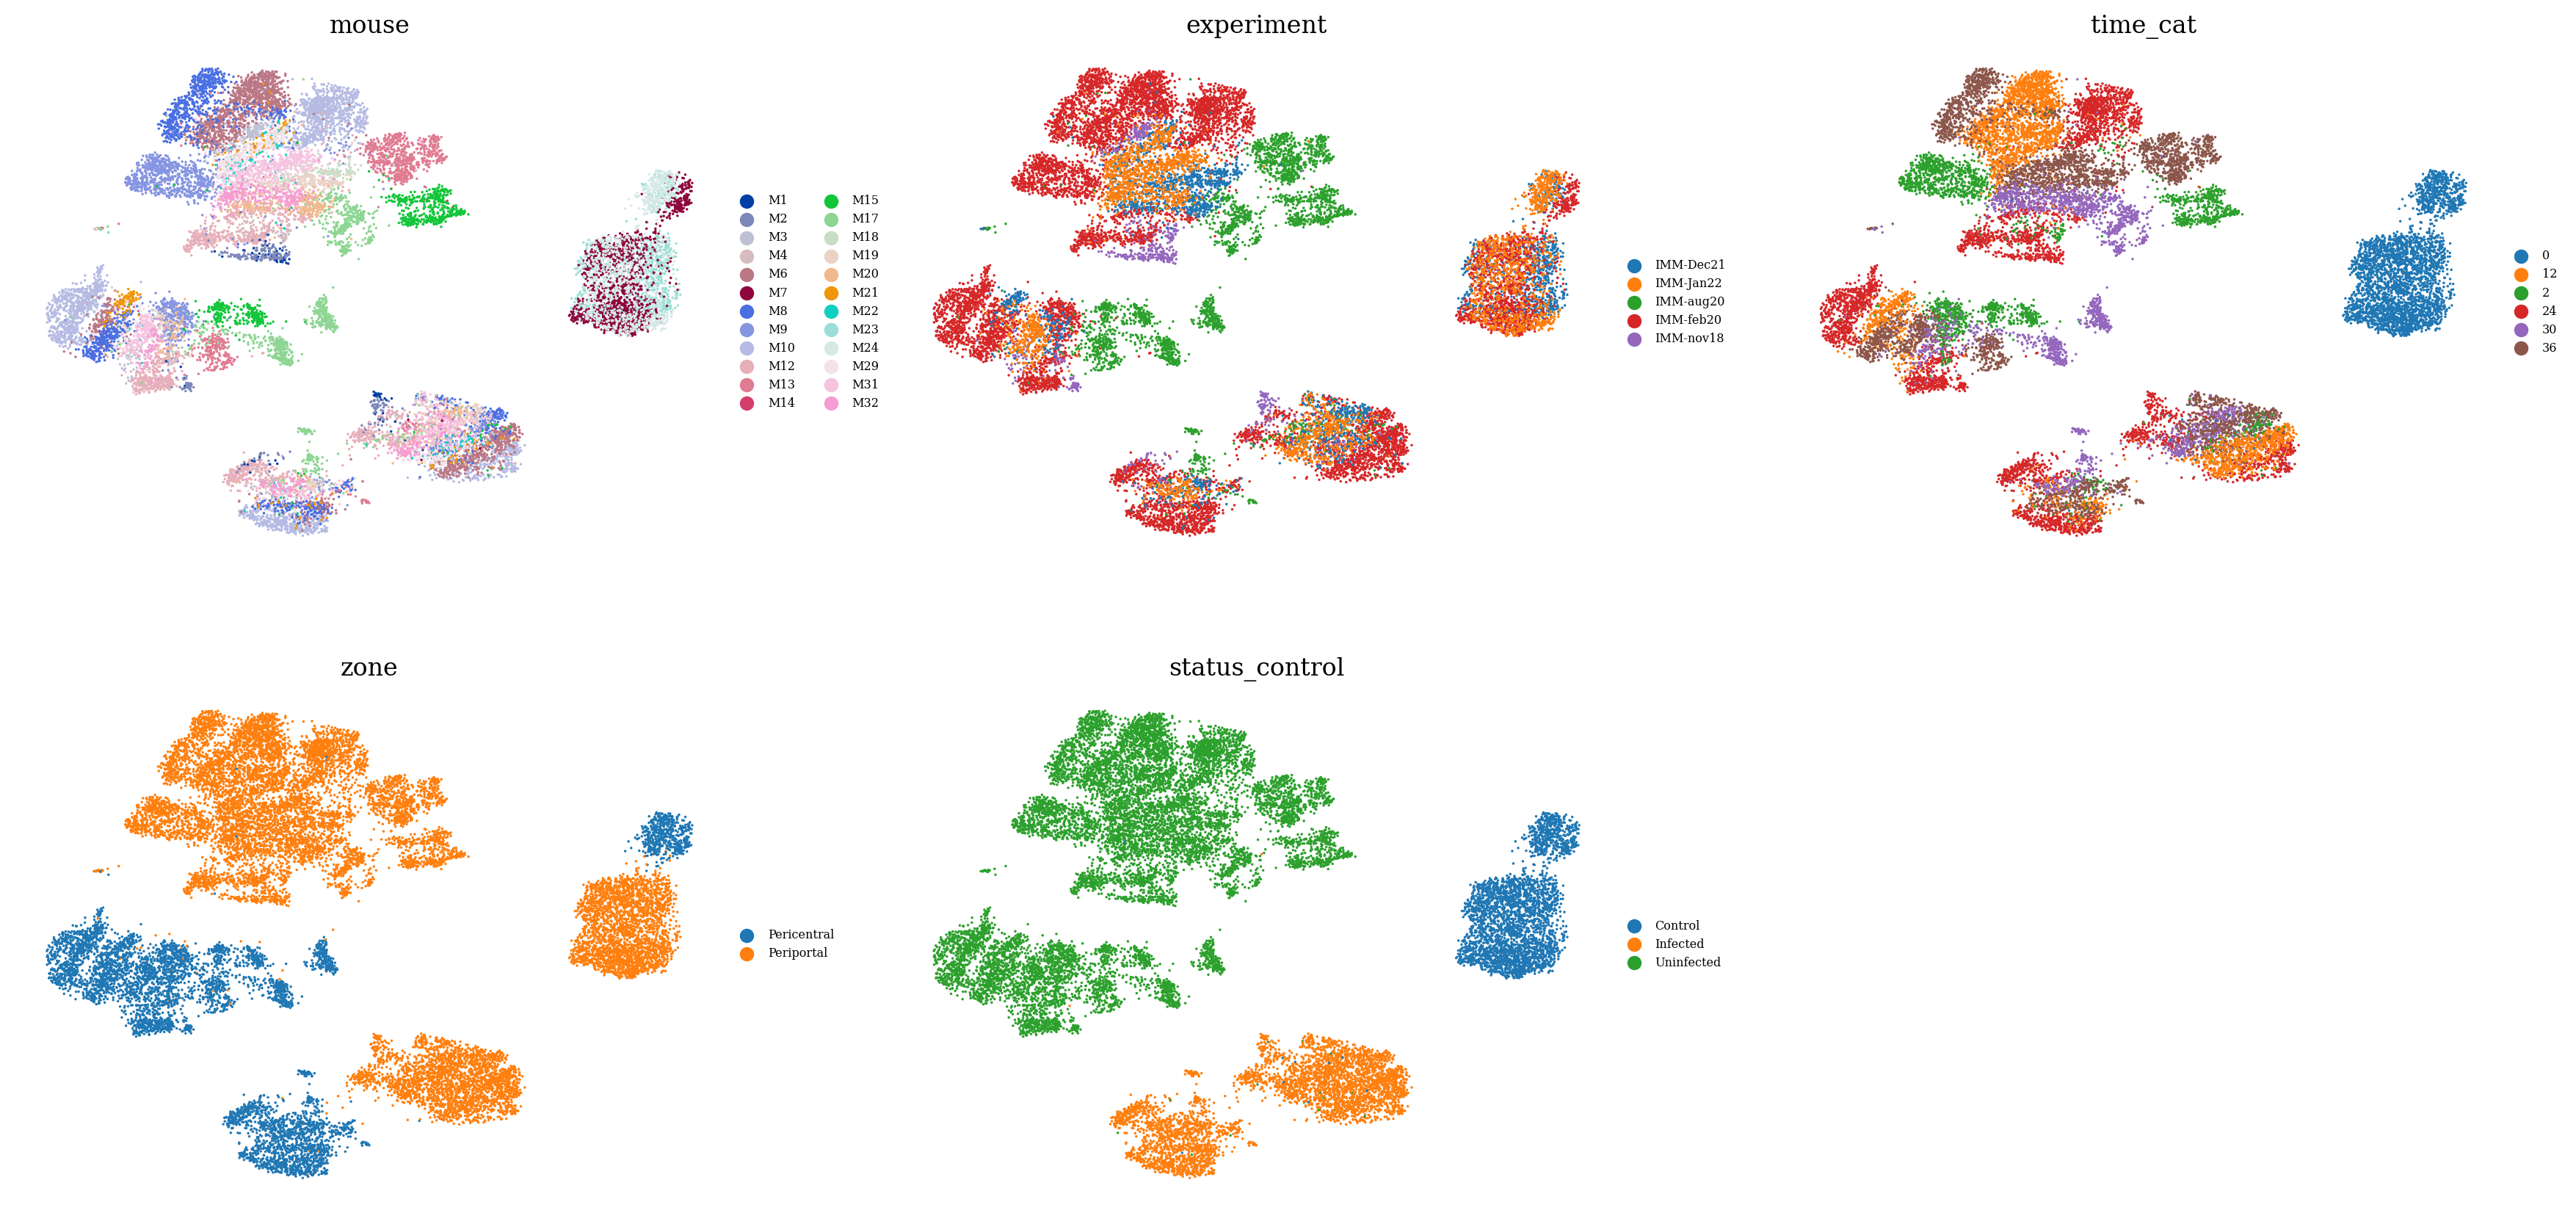

In [18]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

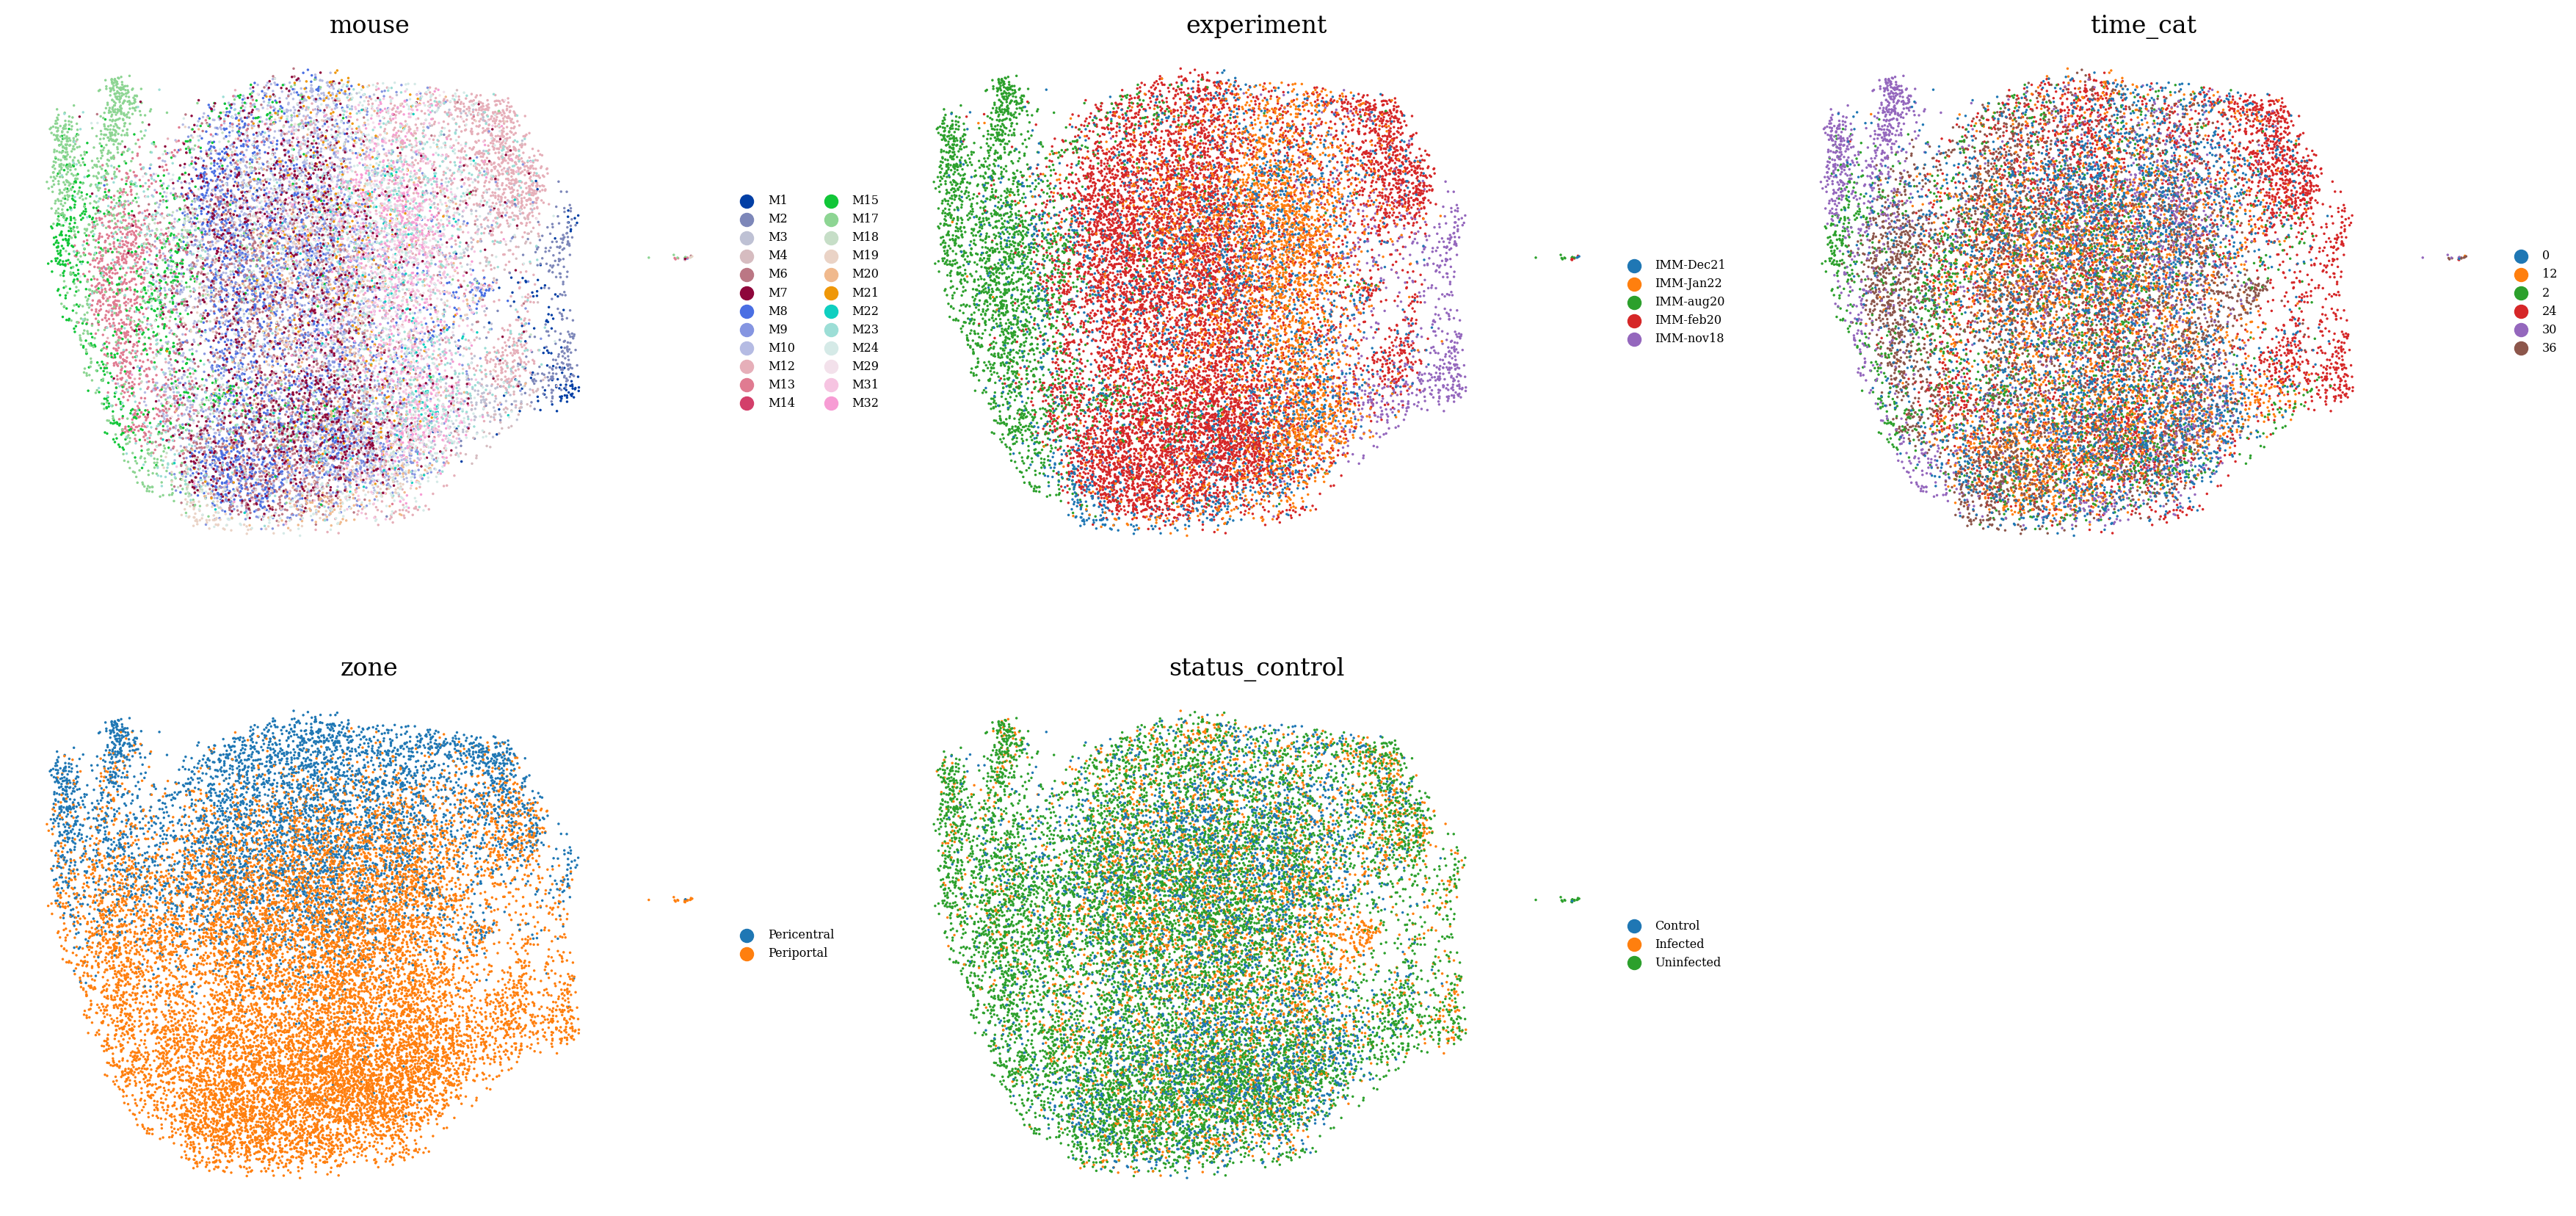

In [19]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [20]:
model.predict()

  0%|          | 0/596 [00:00<?, ?it/s]

  0%|          | 1/596 [00:00<04:17,  2.31it/s]

  0%|          | 2/596 [00:00<03:51,  2.57it/s]

  1%|          | 3/596 [00:01<03:43,  2.65it/s]

  1%|          | 4/596 [00:01<03:39,  2.69it/s]

  1%|          | 5/596 [00:01<03:37,  2.72it/s]

  1%|          | 6/596 [00:02<03:35,  2.73it/s]

  1%|          | 7/596 [00:02<03:35,  2.73it/s]

  1%|▏         | 8/596 [00:02<03:34,  2.74it/s]

  2%|▏         | 9/596 [00:03<03:34,  2.74it/s]

  2%|▏         | 10/596 [00:03<03:33,  2.74it/s]

  2%|▏         | 11/596 [00:04<03:32,  2.75it/s]

  2%|▏         | 12/596 [00:04<03:32,  2.75it/s]

  2%|▏         | 13/596 [00:04<03:31,  2.75it/s]

  2%|▏         | 14/596 [00:05<03:31,  2.75it/s]

  3%|▎         | 15/596 [00:05<03:31,  2.75it/s]

  3%|▎         | 16/596 [00:05<03:31,  2.75it/s]

  3%|▎         | 17/596 [00:06<03:31,  2.74it/s]

  3%|▎         | 18/596 [00:06<03:30,  2.74it/s]

  3%|▎         | 19/596 [00:06<03:30,  2.74it/s]

  3%|▎         | 20/596 [00:07<03:30,  2.74it/s]

  4%|▎         | 21/596 [00:07<03:31,  2.72it/s]

  4%|▎         | 22/596 [00:08<03:29,  2.74it/s]

  4%|▍         | 23/596 [00:08<03:29,  2.74it/s]

  4%|▍         | 24/596 [00:08<03:28,  2.74it/s]

  4%|▍         | 25/596 [00:09<03:28,  2.74it/s]

  4%|▍         | 26/596 [00:09<03:29,  2.73it/s]

  5%|▍         | 27/596 [00:09<03:27,  2.74it/s]

  5%|▍         | 28/596 [00:10<03:26,  2.75it/s]

  5%|▍         | 29/596 [00:10<03:26,  2.75it/s]

  5%|▌         | 30/596 [00:10<03:25,  2.75it/s]

  5%|▌         | 31/596 [00:11<03:25,  2.75it/s]

  5%|▌         | 32/596 [00:11<03:25,  2.75it/s]

  6%|▌         | 33/596 [00:12<03:24,  2.75it/s]

  6%|▌         | 34/596 [00:12<03:24,  2.75it/s]

  6%|▌         | 35/596 [00:12<03:23,  2.76it/s]

  6%|▌         | 36/596 [00:13<03:23,  2.76it/s]

  6%|▌         | 37/596 [00:13<03:22,  2.76it/s]

  6%|▋         | 38/596 [00:13<03:22,  2.76it/s]

  7%|▋         | 39/596 [00:14<03:22,  2.76it/s]

  7%|▋         | 40/596 [00:14<03:21,  2.76it/s]

  7%|▋         | 41/596 [00:14<03:21,  2.76it/s]

  7%|▋         | 42/596 [00:15<03:21,  2.76it/s]

  7%|▋         | 43/596 [00:15<03:20,  2.76it/s]

  7%|▋         | 44/596 [00:16<03:21,  2.74it/s]

  8%|▊         | 45/596 [00:16<03:20,  2.75it/s]

  8%|▊         | 46/596 [00:16<03:19,  2.75it/s]

  8%|▊         | 47/596 [00:17<03:19,  2.75it/s]

  8%|▊         | 48/596 [00:17<03:18,  2.75it/s]

  8%|▊         | 49/596 [00:17<03:18,  2.75it/s]

  8%|▊         | 50/596 [00:18<03:18,  2.76it/s]

  9%|▊         | 51/596 [00:18<03:17,  2.76it/s]

  9%|▊         | 52/596 [00:18<03:17,  2.76it/s]

  9%|▉         | 53/596 [00:19<03:16,  2.76it/s]

  9%|▉         | 54/596 [00:19<03:16,  2.76it/s]

  9%|▉         | 55/596 [00:20<03:16,  2.75it/s]

  9%|▉         | 56/596 [00:20<03:16,  2.75it/s]

 10%|▉         | 57/596 [00:20<03:15,  2.75it/s]

 10%|▉         | 58/596 [00:21<03:15,  2.75it/s]

 10%|▉         | 59/596 [00:21<03:14,  2.76it/s]

 10%|█         | 60/596 [00:21<03:14,  2.75it/s]

 10%|█         | 61/596 [00:22<03:14,  2.75it/s]

 10%|█         | 62/596 [00:22<03:13,  2.76it/s]

 11%|█         | 63/596 [00:22<03:13,  2.76it/s]

 11%|█         | 64/596 [00:23<03:12,  2.76it/s]

 11%|█         | 65/596 [00:23<03:12,  2.76it/s]

 11%|█         | 66/596 [00:24<03:12,  2.76it/s]

 11%|█         | 67/596 [00:24<03:11,  2.76it/s]

 11%|█▏        | 68/596 [00:24<03:11,  2.76it/s]

 12%|█▏        | 69/596 [00:25<03:11,  2.76it/s]

 12%|█▏        | 70/596 [00:25<03:10,  2.76it/s]

 12%|█▏        | 71/596 [00:25<03:10,  2.76it/s]

 12%|█▏        | 72/596 [00:26<03:09,  2.76it/s]

 12%|█▏        | 73/596 [00:26<03:09,  2.76it/s]

 12%|█▏        | 74/596 [00:26<03:09,  2.76it/s]

 13%|█▎        | 75/596 [00:27<03:08,  2.76it/s]

 13%|█▎        | 76/596 [00:27<03:08,  2.76it/s]

 13%|█▎        | 77/596 [00:28<03:08,  2.76it/s]

 13%|█▎        | 78/596 [00:28<03:08,  2.75it/s]

 13%|█▎        | 79/596 [00:28<03:07,  2.76it/s]

 13%|█▎        | 80/596 [00:29<03:07,  2.76it/s]

 14%|█▎        | 81/596 [00:29<03:07,  2.75it/s]

 14%|█▍        | 82/596 [00:29<03:06,  2.75it/s]

 14%|█▍        | 83/596 [00:30<03:06,  2.75it/s]

 14%|█▍        | 84/596 [00:30<03:06,  2.75it/s]

 14%|█▍        | 85/596 [00:30<03:06,  2.74it/s]

 14%|█▍        | 86/596 [00:31<03:05,  2.74it/s]

 15%|█▍        | 87/596 [00:31<03:06,  2.72it/s]

 15%|█▍        | 88/596 [00:32<03:37,  2.33it/s]

 15%|█▍        | 89/596 [00:32<03:28,  2.43it/s]

 15%|█▌        | 90/596 [00:33<03:20,  2.53it/s]

 15%|█▌        | 91/596 [00:33<03:15,  2.59it/s]

 15%|█▌        | 92/596 [00:33<03:11,  2.64it/s]

 16%|█▌        | 93/596 [00:34<03:08,  2.67it/s]

 16%|█▌        | 94/596 [00:34<03:06,  2.69it/s]

 16%|█▌        | 95/596 [00:34<03:04,  2.71it/s]

 16%|█▌        | 96/596 [00:35<03:03,  2.73it/s]

 16%|█▋        | 97/596 [00:35<03:02,  2.74it/s]

 16%|█▋        | 98/596 [00:35<03:01,  2.74it/s]

 17%|█▋        | 99/596 [00:36<03:00,  2.75it/s]

 17%|█▋        | 100/596 [00:36<03:00,  2.75it/s]

 17%|█▋        | 101/596 [00:36<02:59,  2.75it/s]

 17%|█▋        | 102/596 [00:37<02:59,  2.76it/s]

 17%|█▋        | 103/596 [00:37<02:58,  2.76it/s]

 17%|█▋        | 104/596 [00:38<02:58,  2.75it/s]

 18%|█▊        | 105/596 [00:38<02:59,  2.74it/s]

 18%|█▊        | 106/596 [00:38<02:57,  2.75it/s]

 18%|█▊        | 107/596 [00:39<02:57,  2.75it/s]

 18%|█▊        | 108/596 [00:39<02:57,  2.75it/s]

 18%|█▊        | 109/596 [00:39<02:56,  2.76it/s]

 21%|██        | 124/596 [00:39<00:25, 18.30it/s]

 25%|██▌       | 149/596 [00:40<00:09, 48.65it/s]

 29%|██▉       | 175/596 [00:40<00:05, 81.53it/s]

 34%|███▎      | 200/596 [00:40<00:03, 112.28it/s]

 38%|███▊      | 226/596 [00:40<00:02, 142.20it/s]

 42%|████▏     | 252/596 [00:40<00:02, 167.55it/s]

 47%|████▋     | 278/596 [00:40<00:01, 188.45it/s]

 51%|█████     | 302/596 [00:40<00:01, 201.54it/s]

 55%|█████▍    | 327/596 [00:40<00:01, 214.32it/s]

 59%|█████▉    | 352/596 [00:40<00:01, 223.62it/s]

 63%|██████▎   | 377/596 [00:41<00:00, 230.00it/s]

 67%|██████▋   | 402/596 [00:41<00:00, 235.07it/s]

 72%|███████▏  | 427/596 [00:41<00:00, 238.70it/s]

 76%|███████▌  | 453/596 [00:41<00:00, 242.93it/s]

 80%|████████  | 479/596 [00:41<00:00, 245.67it/s]

 85%|████████▍ | 504/596 [00:41<00:00, 245.82it/s]

 89%|████████▉ | 530/596 [00:41<00:00, 248.20it/s]

 93%|█████████▎| 555/596 [00:41<00:00, 247.19it/s]

 97%|█████████▋| 580/596 [00:41<00:00, 246.76it/s]

100%|██████████| 596/596 [00:41<00:00, 14.23it/s] 

In [21]:
pred_adata = adata[model.test_indices]
true = np.array(pred_adata.X)
pred = np.array(pred_adata.obsm["CPA_pred"])

In [22]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    print(start_ind, end_ind)
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind


0

32

32

64

64

96

96

128

128

160

160

192

192

224

224

256

256

288

288

320

320

352

352

384

384

416

416

448

448

480

480

512

512

544

544

576

576

608

608

640

640

672

672

704

In [23]:
np.mean(r2s)

0.9795374634188595

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)